# HybridNetv7 | HE

**Version**: 7.1.2<br>
**Date**: Sat Sep 13th, 2025<br>
**Author**: Jakob Balkovec<br>

**Model**:

```txt
From latest run:

=== TEST SUMMARY (HE-only) ===
Dice      = 0.4460
IoU       = 0.3422
Precision = 0.4183
Recall    = 0.3602
Pearson   = 0.4143
Thr       = 0.55
```

---
## Packages

In [1]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 7.6 MB/s eta 0:00:00


## Imports

In [2]:
# standard library
import os
import random
import importlib
import math
import time
import csv
import gc
from datetime import datetime
import json
import shutil
from typing import Dict, Any

# TP
import numpy as np
import pandas as pd
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2
from scipy.stats import pearsonr

# PyT
import torch
from torch import amp
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
from torch.utils.data import WeightedRandomSampler
from torchvision import models
from torch.special import logit
from torch.utils.data import WeightedRandomSampler

# TV
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode

# SKL
from skmultilearn.model_selection import iterative_train_test_split

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"\nusing: {device}")
assert device.type == "cuda", "CUDA device not available || still in CPU mode"


using: cuda



## Configuration

In [3]:
# === HE-only configuration (pivoted from EX) ===
# HE is index=1 in [MA, HE, EX, SE]
HE_IDX = 1

config = {
    "MASTER_DF_PATH": "/content/patches/patches/master_df.pkl",
    "IMAGE_ROOT": "/content/images/Original_Images",
    "PATCHES_ROOT": "/content/patches/",
    "MASK_DIR": "/content/masks",
    "OUTPUT_DIR": "/content/output",
    "DRIVE_MODEL_DIR": "/content/drive/MyDrive/models",
    "DRIVE_MODEL_PATH": "/content/drive/MyDrive/models/hybridnet_v7_HE.pth",  # was EX

    "SEED": 42,

    "IMG_SIZE": 512,

    "PATCH_SIZE": 128,

    "BATCH_SIZE": 1,
    "EPOCHS": 50,
    "VAL_INTERVAL": 1,

    "FIXED_PATCHES_VAL": 96,
    "FIXED_PATCHES_TRAIN": 48,

    "PATCH_POS_RATIO": 0.55,   # was 0.65

    "DEC_FUSION": "concat",
    "DEC_BLOCK": "res",
    "DEC_C": 320,
    "USE_CTX_GATE": True,
    "USE_REFINE":   True,

    "ACCUM_STEPS": 4,
    "NUM_WORKERS": max(0, min(4, (os.cpu_count() or 2)//2)),
    "NUM_CLASSES": 1,  # HE-only

    "LOSS_TYPE": "focal_tversky", # bce_softdice
    "BCE_WEIGHT": 0.55,

    # Fine-tuning and Dice/Tversky knobs
    "TV_ALPHA": 0.7,
    "TV_BETA": 0.3,
    "FT_GAMMA": 0.75,
    "FT_LAMBDA": 0.7,

    # Focal-Tversky extras
    "FT_CLAMP_PROBS": True,
    "FT_IGNORE_EMPTY": True,
    "FT_EPS": 1e-6,
    "FT_BCE_ALPHA": 0.05,

    "POSW_CAP": 22.0,
    "CLASSW_POWER": 1.0,
    "CLASSW_CAP": 4.0,

    "AUX_USE_BCE": True,
    "AUX_WEIGHTS": [1.0, 0.3, 0.15],  # keep

    "COV_RATIOS": 0.02,
    "POS_WEIGHT": 1.0,
    "CLASS_WEIGHT": 1.0,

    # Optimizer / scheduler
    "LR": 1e-4,
    "LR_MIN": 1e-6,
    "WEIGHT_DECAY": 1e-4,
    "LR_FACTOR": 0.5,
    "LR_PATIENCE": 2,
    "WARMUP_STEPS": 500,
    "MAX_NORM": 1.0,
    "USE_EMA": False,

    "PATCH_CHUNK": 25,

    "USE_GLOBAL_FILM": False, # ***** try with true ******

    "MODE": "blend",

    "POST_MIN_AREA": 24,        # was 12

    "EARLY_STOP_MONITOR": "val_dice",
    "EARLY_STOP_MODE": "max",
    "EARLY_STOP_PATIENCE": 12,
    "EARLY_STOP_MIN_DELTA": 0.002,

    "MAX_TIME_MIN": 120,
    "LOSS_SPIKE_FACTOR": 3.0,

    "TRAIN_FRAC": 0.70,
    "VAL_FRAC": 0.15,
    "TEST_FRAC": 0.15,
    "FORCE_RESPLIT": False,

    "RUN_MODE": "",

    # Start slightly below 0.5. Will be tuned.
    "THRESH": 0.45
}

mp_config = {
    "NUM_WORKERS": max(0, min(4, (os.cpu_count() or 2)//2)),  # heuristic
    "PERSISTENT_WORKERS": True,
    "PREFETCH_FACTOR": 2,
    "PIN_MEMORY": (device.type == 'cuda'),
    "TIMEOUT": 0,
    "MP_CONTEXT": "fork"
}

#### Sanity Checks

In [4]:
assert isinstance(config["NUM_CLASSES"], int) and config["NUM_CLASSES"] == 1
for k in ["COV_RATIOS", "POS_WEIGHT", "CLASS_WEIGHT"]:
    assert isinstance(config[k], (int, float)), f"{k} must be scalar for EX-only"
assert "THRESH" in config and not isinstance(config["THRESH"], (list, tuple)), "Use scalar THRESH for EX-only"


## History Tracking

In [5]:
HISTORY = {
    "train_loss": [],
    "train_dice": [],
    "train_iou": [],
    "train_pearson": [],

    "val_loss": [],
    "val_dice": [],
    "val_iou": [],
    "val_pearson": [],

    "val_dice_ema": [],
}

## Environment

In [6]:
gc.collect()
torch.cuda.empty_cache()

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

BOOSTS = {
    "HE": 1.5,
}

LESION_COLORS = {
    "HE": (1.0, 0.0, 0.0),   # red
}
LESION_NAMES = ["HE"]

torch.manual_seed(config["SEED"])
np.random.seed(config["SEED"])
random.seed(config["SEED"])

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

os.makedirs(config["OUTPUT_DIR"], exist_ok=True)
os.makedirs(config["DRIVE_MODEL_DIR"], exist_ok=True)

METRICS_DIR = os.path.join(config["OUTPUT_DIR"], "metrics_logs")
VISUALS_DIR = os.path.join(config["OUTPUT_DIR"], "visuals")
PREDICTIONS_DIR = os.path.join(config["OUTPUT_DIR"], "predictions")

for d in [METRICS_DIR, VISUALS_DIR, PREDICTIONS_DIR]:
    os.makedirs(d, exist_ok=True)

SPLIT_CSV = os.path.join(METRICS_DIR, "image_split.csv")
SPLIT_SUMMARY_CSV = os.path.join(METRICS_DIR, "split_summary.csv")
os.makedirs(os.path.dirname(SPLIT_CSV), exist_ok=True)

## Multiprocessing Context

In [7]:
class NopDS(Dataset):
    def __len__(self): return 64
    def __getitem__(self, i): return torch.zeros(3,16,16), i

def try_ctx(ctx_name):
    print(f"\n=== testing multiprocessing_context='{ctx_name}' ===")
    ctx = mp.get_context(ctx_name)
    loader = DataLoader(
        NopDS(), batch_size=8, shuffle=False,
        num_workers=2,
        multiprocessing_context=ctx,
        persistent_workers=False,
        pin_memory=False,
        prefetch_factor=2,
        timeout=0,
    )
    b = next(iter(loader))
    print("OK:", b[0].shape, b[1][:4])

for name in ["forkserver", "spawn", "fork"]:
    try:
        try_ctx(name)
    except Exception as e:
        print(f"FAILED ({name}): {type(e).__name__}: {e}")

try:
    mp.set_sharing_strategy("file_system")
except Exception as e:
    print("set_sharing_strategy:", e)

try:
    mp.set_start_method("fork", force=True) # or forkserver
    importlib.reload(torch.utils.data)
except RuntimeError as e:
    print("set_start_method:", e)

print("start_method:    ", mp.get_start_method(allow_none=True))
print("sharing_strategy:", mp.get_sharing_strategy())


=== testing multiprocessing_context='forkserver' ===
FAILED (forkserver): RuntimeError: DataLoader worker (pid(s) 1430, 1431) exited unexpectedly

=== testing multiprocessing_context='spawn' ===
FAILED (spawn): RuntimeError: DataLoader worker (pid(s) 1459, 1460) exited unexpectedly

=== testing multiprocessing_context='fork' ===
OK: torch.Size([8, 3, 16, 16]) tensor([0, 1, 2, 3])
start_method:     fork
sharing_strategy: file_system


## Drive

In [8]:
if os.path.isdir('/content/drive') and os.listdir('/content/drive'):
    print("non-empty mountpoint")

    # unmount
    if os.path.ismount('/content/drive'):
        drive.flush_and_unmount()
        print("drive unmounted.")

    !rm -rf /content/drive/*

# mount
drive.mount('/content/drive', force_remount=True)

non-empty mountpoint
Mounted at /content/drive


## Data

In [9]:
# extract "pathces.7z"
!7z x "/content/drive/MyDrive/patches.7z" -o"/content/patches" -y

# unzip "images.zip"
!unzip "/content/drive/MyDrive/images.zip" -d /content/images

# unzip "masks.zip"
!unzip "/content/drive/MyDrive/masks.zip" -d /content/masks

Izpis pretočnega predvajanja je skrajšan na toliko zadnjih vrstic: 5000.
  inflating: /content/masks/Hemorrhage_Masks/0921_1.png  
  inflating: /content/masks/Hemorrhage_Masks/1080_3.png  
  inflating: /content/masks/Hemorrhage_Masks/1226_1.png  
  inflating: /content/masks/Hemorrhage_Masks/0226_1.png  
  inflating: /content/masks/Hemorrhage_Masks/0263_1.png  
  inflating: /content/masks/Hemorrhage_Masks/0999_1.png  
  inflating: /content/masks/Hemorrhage_Masks/1750_3.png  
  inflating: /content/masks/Hemorrhage_Masks/0803_3.png  
  inflating: /content/masks/Hemorrhage_Masks/1278_2.png  
  inflating: /content/masks/Hemorrhage_Masks/1491_3.png  
  inflating: /content/masks/Hemorrhage_Masks/1573_1.png  
  inflating: /content/masks/Hemorrhage_Masks/0728_3.png  
  inflating: /content/masks/Hemorrhage_Masks/0304_3.png  
  inflating: /content/masks/Hemorrhage_Masks/0341_3.png  
  inflating: /content/masks/Hemorrhage_Masks/0959_1.png  
  inflating: /content/masks/Hemorrhage_Masks/1611_2.png  

## Frame

In [10]:
patch_df = pd.read_pickle(config["MASTER_DF_PATH"])
patch_df.head(n=2)

image_id          patch_id                                file_path  \
0   0000_1  0000_1_1216_1216  patches/0000_1/all/0000_1_1216_1216.png   
1   0000_1    0000_1_832_320    patches/0000_1/all/0000_1_832_320.png   

  filter_tag                                        coordinates  \
0      black  {'top-left': (1152, 1152), 'top-right': (1279,...   
1    healthy  {'top-left': (768, 256), 'top-right': (895, 25...   

                   center  label_vector  
0  {'x': 1216, 'y': 1216}  [0, 0, 0, 0]  
1    {'x': 832, 'y': 320}  [0, 0, 0, 0]

## Utility Functions `SPLIT`

In [11]:
def _merge_labels(label_list):
    arr = np.vstack(label_list).astype(int)
    return np.clip(arr.sum(axis=0), 0, 1).tolist()

# public
def summarize_split(name, idx, Y):
    subset = Y[idx]

    if subset.ndim == 1 or (subset.ndim == 2 and subset.shape[1] == 1):
        counts = int(subset.sum())
        rates  = float(subset.mean().round(4))
    else:
        counts = subset.sum(axis=0).tolist()
        rates  = subset.mean(axis=0).round(4).tolist()
    return {"name": name, "n": int(len(idx)), "counts": counts, "rates": rates}


def stratified_split(image_df, train_frac=0.7, val_frac=0.15, seed=42):
    rng = np.random.RandomState(seed)
    X = np.arange(len(image_df)).reshape(-1, 1)
    Y = np.array(image_df["image_label"].to_list())

    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)

    X_train, Y_train, X_tmp, Y_tmp = iterative_train_test_split(
        X, Y, test_size=(1 - train_frac)
    )

    val_frac_rel = val_frac / (1 - train_frac)
    X_val, Y_val, X_test, Y_test = iterative_train_test_split(
        X_tmp, Y_tmp, test_size=(1 - val_frac_rel)
    )

    idx_train = X_train.ravel()
    idx_val   = X_val.ravel()
    idx_test  = X_test.ravel()

    split = np.full(len(image_df), "train", dtype=object)
    split[idx_val]  = "val"
    split[idx_test] = "test"

    image_df = image_df.copy()
    image_df["split"] = split
    return image_df

# private
def _summarize(name, idx, Y):
    subset = Y[idx]
    if subset.ndim == 1 or (subset.ndim == 2 and subset.shape[1] == 1):
        counts = int(subset.sum())
        rates  = float(np.round(subset.mean(), 4))
    else:
        counts = subset.sum(axis=0).astype(int).tolist()
        rates  = subset.mean(axis=0).round(4).tolist()
    return {"name": name, "n": int(len(idx)), "counts": counts, "rates": rates}

# guards
def _to_he_only(lbl):
    # lbl may be int, [int], or [4-d vector]
    if isinstance(lbl, (int, np.integer)):
        return int(lbl)
    if isinstance(lbl, (list, tuple, np.ndarray)):
        if len(lbl) == 4:
            return int(lbl[HE_IDX])
        if len(lbl) == 1:
            return int(lbl[0])
    raise ValueError(f"Unexpected label format for HE-only: {type(lbl)} -> {lbl}")

## Split

In [12]:
assert abs(config["TRAIN_FRAC"] + config["VAL_FRAC"] + config["TEST_FRAC"] - 1.0) < 1e-9

need_cols = {"image_id", "label_vector", "file_path"}
missing = need_cols - set(patch_df.columns)
assert not missing, f"patch_df missing columns: {missing}"

# HE is index=1 in [MA, HE, EX, SE]
HE_IDX = 1

def _to_single_idx(v, idx: int) -> int:
    """Return binary presence for a single class index from a multi-hot vector."""
    arr = np.asarray(v).astype(int).reshape(-1)
    assert arr.size > idx, f"label vector too short for idx={idx}: {arr}"
    return int(arr[idx])

image_df = (
    patch_df.groupby("image_id", as_index=False)["label_vector"]
            .apply(lambda s: _merge_labels(list(s)))
            .rename(columns={"label_vector": "image_label"})
)

# Convert multi-class vector to single HE label
image_df["image_label"] = image_df["image_label"].apply(lambda v: _to_single_idx(v, HE_IDX))

image_df["image_path"] = image_df["image_id"].apply(
    lambda x: os.path.join(config["IMAGE_ROOT"], f"{x}.png")
)

Y = np.array(image_df["image_label"].to_list(), dtype=int)
if Y.ndim == 1:
    Y = Y.reshape(-1, 1)
assert Y.shape[1] == 1, f"Expected single HE label, got shape {Y.shape}"
N = len(image_df)

if config["FORCE_RESPLIT"] or not os.path.isfile(SPLIT_CSV):
    image_df = stratified_split(
        image_df,
        train_frac=config["TRAIN_FRAC"],
        val_frac=config["VAL_FRAC"],
        seed=config["SEED"],
    )
    image_df[["image_id", "split"]].to_csv(SPLIT_CSV, index=False)
else:
    prev = pd.read_csv(SPLIT_CSV)
    image_df = image_df.merge(prev, on="image_id", how="left")
    image_df["split"] = image_df["split"].fillna("train")

image_split_map = dict(zip(image_df["image_id"], image_df["split"]))
patch_df["split"] = patch_df["image_id"].map(image_split_map)
assert patch_df["split"].notna().all()

idx_train = image_df.index[image_df["split"] == "train"].to_numpy()
idx_val   = image_df.index[image_df["split"] == "val"].to_numpy()
idx_test  = image_df.index[image_df["split"] == "test"].to_numpy()

summary = [
    _summarize("train",   idx_train, Y),
    _summarize("val",     idx_val,   Y),
    _summarize("test",    idx_test,  Y),
    _summarize("overall", np.arange(N), Y),
]

df_summary = pd.DataFrame(summary)
os.makedirs(os.path.dirname(SPLIT_SUMMARY_CSV), exist_ok=True)
df_summary.to_csv(SPLIT_SUMMARY_CSV, index=False)
print(df_summary)

for split_name in ["train", "val", "test"]:
    row = df_summary[df_summary["name"] == split_name].iloc[0]
    counts = row["counts"] if isinstance(row["counts"], list) else [row["counts"]]
    if counts[0] == 0:
        print(f"[WARN] Split '{split_name}' has zero HE positives.")

      name     n  counts   rates
0    train  1289    1019  0.7905
1      val   277     218  0.7870
2     test   276     219  0.7935
3  overall  1842    1456  0.7904


## Dataset

In [13]:
class PatchSegDataset(Dataset):
    class _AlbuNoOp:
        def __call__(self, **kwargs):
            return kwargs

    def __init__(self,
                 patch_df,
                 image_dir,
                 patches_root,
                 mask_dir,
                 transform_img,
                 transform_patch,
                 transform_mask,
                 fixed_patches_train=48,
                 fixed_patches_val=None,
                 seed=42,
                 train_mode=True,
                 joint_tf=None):
        self.image_dir = image_dir
        self.patches_root = patches_root
        self.mask_dir = mask_dir

        self.transform_img   = transform_img or self._AlbuNoOp()
        self.transform_patch = transform_patch or self._AlbuNoOp()
        self.transform_mask  = transform_mask or self._AlbuNoOp()
        self.joint_tf        = joint_tf

        self.train_mode = bool(train_mode)
        self.fixed_patches_train = fixed_patches_train
        self.fixed_patches_val   = fixed_patches_val

        self.seed = int(seed)
        self.rng = np.random.default_rng(self.seed)

        # ---- lesion selection (defaults to HE) ----
        # Multi-hot ordering: [MA, HE, EX, SE]
        self.lesion_idx  = int(config.get("LESION_IDX", 1))           # 1 => HE
        self.lesion_name = str(config.get("LESION_NAME", "HE")).upper()

        # I forgot what I saved them as in the zip file...
        candidates = {
            "HE": [
                "Hemorrhage_Masks",
                "Hemorrhages_Masks",
                "mask_HE",
                "HE_Masks",
                "HE"
            ],
            "EX": ["HardExudate_Masks", "mask_EX", "EX_Masks", "EX"],
            "MA": ["Microaneurysm_Masks", "mask_MA", "MA_Masks", "MA"],
            "SE": ["SoftExudate_Masks", "CottonWool_Masks", "mask_SE", "SE_Masks", "SE"],
        }
        want = candidates.get(self.lesion_name, [self.lesion_name])
        self.mask_subdir = None
        for sd in want:
            p = os.path.join(self.mask_dir, sd)
            if os.path.isdir(p):
                self.mask_subdir = sd
                break
        # Fall back to first candidate (will yield all-zero masks if not present)
        if self.mask_subdir is None:
            self.mask_subdir = want[0]

        # ---- build per-image positive/negative patch lists ----
        self.image_ids = []
        self.pos_lists = []
        self.neg_lists = []

        for image_id, g in patch_df.groupby("image_id"):
            g = g.sort_values(by=["center_y", "center_x"], ascending=True) if "center_y" in g.columns else g

            pos_paths, neg_paths = [], []
            for pth, lv in zip(g["file_path"].tolist(), g["label_vector"].tolist()):
                full = pth if os.path.isabs(pth) else os.path.join(self.patches_root, pth)
                if isinstance(lv, (list, tuple, np.ndarray)):
                    lv = np.asarray(lv).astype(int).reshape(-1)
                    pos = bool(lv[self.lesion_idx]) if self.lesion_idx < lv.size else bool(lv[-1])
                else:
                    pos = bool(lv)
                (pos_paths if pos else neg_paths).append(full)

            self.image_ids.append(image_id)
            self.pos_lists.append(pos_paths)
            self.neg_lists.append(neg_paths)

        self.val_cache = {} if (not self.train_mode and self.fixed_patches_val is not None) else None

    def __len__(self):
        return len(self.image_ids)

    def set_epoch(self, epoch: int):
        if self.train_mode:
            self.rng = np.random.default_rng(self.seed + int(epoch))

    def _sample_without_replacement(self, arr, k):
        if k <= 0 or len(arr) == 0:
            return []
        k = min(k, len(arr))
        idx = self.rng.choice(len(arr), size=k, replace=False)
        return [arr[i] for i in idx]

    def _sample_with_replacement(self, arr, k):
        if k <= 0 or len(arr) == 0:
            return []
        idx = self.rng.integers(0, len(arr), size=k)
        return [arr[i] for i in idx]

    def _choose_patches_pos_neg(self, idx, k, pos_ratio):
        pos = self.pos_lists[idx]
        neg = self.neg_lists[idx]

        if k is None:
            return pos + neg

        k_pos = int(round(k * float(pos_ratio)))
        k_neg = max(0, k - k_pos)

        sel = []

        if k_pos > 0 and len(pos) > 0:
            take = min(k_pos, len(pos))
            sel += self._sample_without_replacement(pos, take)
            if take < k_pos:
                sel += self._sample_with_replacement(pos, k_pos - take)

        if k_neg > 0 and len(neg) > 0:
            sel += self._sample_without_replacement(neg, k_neg)

        if len(sel) < k:
            pool = pos + neg
            need = k - len(sel)
            if len(pool) > 0:
                add = self._sample_with_replacement(pool, need if need > len(pool) else need)
                sel += add

        return sel[:k]

    def __getitem__(self, idx):
        # recursive resampling helper
        def _load_item(i):
            image_id = self.image_ids[i]
            img_path = os.path.join(self.image_dir, f"{image_id}.png")
            img_pil  = Image.open(img_path).convert("RGB")
            img_np   = np.array(img_pil)

            mp = os.path.join(self.mask_dir, self.mask_subdir, f"{image_id}.png")
            H, W = img_np.shape[:2]
            if os.path.isfile(mp):
                m = Image.open(mp).convert("L")
                m_np = (np.array(m, dtype=np.uint8) > 127).astype(np.uint8)
            else:
                m_np = np.zeros((H, W), dtype=np.uint8)

            # Avoid training on all-negative GT frames if requested
            if self.train_mode and m_np.sum() == 0:
                # Resample a new index
                new_idx = self.rng.integers(0, len(self.image_ids))
                return _load_item(new_idx)

            # convert mask
            mask_hwc = m_np[..., None]

            if self.joint_tf is not None:
                out = self.joint_tf(image=img_np, mask=mask_hwc)
                img_np_tf, mask_hwc_tf = out["image"], out["mask"]
            else:
                out = self.transform_img(image=img_np, mask=mask_hwc)
                img_np_tf, mask_hwc_tf = out.get("image", img_np), out.get("mask", mask_hwc)

            # to tensor (image)
            if isinstance(img_np_tf, torch.Tensor):
                if img_np_tf.ndim == 3 and img_np_tf.shape[0] == 3:
                    image_tensor = img_np_tf.float()
                elif img_np_tf.ndim == 3 and img_np_tf.shape[-1] == 3:
                    image_tensor = img_np_tf.permute(2, 0, 1).float()
                else:
                    raise ValueError(f"Unexpected image shape {tuple(img_np_tf.shape)}")
            else:
                image_tensor = torch.from_numpy(img_np_tf.transpose(2, 0, 1)).float()

            # to tensor (mask)
            if isinstance(mask_hwc_tf, torch.Tensor):
                mask_tensor = mask_hwc_tf if mask_hwc_tf.shape[0] == 1 else mask_hwc_tf.permute(2, 0, 1)
            else:
                mask_tensor = torch.from_numpy(mask_hwc_tf.transpose(2, 0, 1))
            mask_tensor = mask_tensor.contiguous().float().clamp(0, 1)

            # patches
            if self.train_mode:
                k = self.fixed_patches_train
                pos_ratio = float(config.get("PATCH_POS_RATIO", 0.7))
                paths = self._choose_patches_pos_neg(i, k, pos_ratio)
            else:
                k = self.fixed_patches_val
                if k is None:
                    paths = self.pos_lists[i] + self.neg_lists[i]
                else:
                    if self.val_cache is not None:
                        iid = image_id
                        if iid in self.val_cache:
                            paths = self.val_cache[iid]
                        else:
                            allp = self.pos_lists[i] + self.neg_lists[i]
                            if len(allp) <= k:
                                sel = allp
                            else:
                                h = abs(hash((str(iid), self.seed))) % (2**32)
                                rng_local = np.random.default_rng(h)
                                idxs = rng_local.choice(len(allp), size=k, replace=False)
                                sel = [allp[j] for j in idxs]
                            self.val_cache[iid] = sel
                            paths = sel
                    else:
                        paths = self._sample_without_replacement(self.pos_lists[i] + self.neg_lists[i], k)

            pt = []
            for p in paths:
                if os.path.isfile(p):
                    im = Image.open(p).convert("RGB")
                    p_np = np.array(im)
                    out_p = self.transform_patch(image=p_np)
                    p_img = out_p.get("image", p_np)
                    if isinstance(p_img, torch.Tensor):
                        if p_img.ndim == 3 and p_img.shape[0] == 3:
                            img_tensor = p_img.float()
                        elif p_img.ndim == 3 and p_img.shape[-1] == 3:
                            img_tensor = p_img.permute(2, 0, 1).float()
                        else:
                            raise ValueError(f"Unexpected patch shape {tuple(p_img.shape)}")
                    else:
                        img_tensor = torch.from_numpy(p_img.transpose(2, 0, 1)).float()
                    pt.append(img_tensor)

            if len(pt) == 0:
                P = int(config.get("PATCH_SIZE", config["IMG_SIZE"]))
                pt = [torch.zeros(3, P, P, dtype=torch.float32)]

            patch_tensor = torch.stack(pt, dim=0)
            return image_tensor, patch_tensor, mask_tensor

        return _load_item(idx)

## Utility Functions `TRANSFORMS`

In [14]:
def green_clahe(img, clip=2.0, grid=(8,8), mode="blend", alpha=0.75):
    g = img[..., 1]
    clahe = cv2.createCLAHE(clipLimit=float(clip), tileGridSize=tuple(grid))
    g_eq = clahe.apply(g)

    if mode == "replace":
        out = img.copy()
        out[..., 1] = g_eq
        return out
    elif mode == "replicate":
        g3 = np.stack([g_eq, g_eq, g_eq], axis=-1)
        return g3
    elif mode == "blend":
        out = img.astype(np.float32)
        g_eq_f = g_eq.astype(np.float32)
        out[..., 0] = (1 - alpha) * out[..., 0] + alpha * g_eq_f
        out[..., 1] = g_eq_f
        out[..., 2] = (1 - alpha) * out[..., 2] + alpha * g_eq_f
        return np.clip(out, 0, 255).astype(np.uint8)
    else:
        raise ValueError("mode must be one of {'replace','replicate','blend'}")

# since A.lambda isn't compatibile with multiprocessing, i'm making a wrapper...

def green_clahe_transform(x, **kwargs):
    return green_clahe(x, clip=2.0, grid=(8,8), mode=config_mode, alpha=0.75)

def green_clahe_torchvision(pil_img):
    img = np.array(pil_img)
    out = green_clahe(img, clip=2.0, grid=(8,8), mode=config_mode, alpha=0.75)
    return Image.fromarray(out)

def identity_mask(x, **kwargs):
    return x

class GreenCLAHE(ImageOnlyTransform):
    def __init__(self, clip=2.0, grid=(8,8), mode="blend", alpha=0.75, always_apply=False, p=1.0):
        super(GreenCLAHE, self).__init__(always_apply, p)
        self.clip = clip
        self.grid = grid
        self.mode = mode
        self.alpha = alpha

    def apply(self, img, **params):
        return green_clahe(img, clip=self.clip, grid=self.grid, mode=self.mode, alpha=self.alpha)

## Transforms

In [15]:
config_mode = config["MODE"]

P = int(config["PATCH_SIZE"])
IMG_MEAN = IMAGENET_MEAN
IMG_STD  = IMAGENET_STD
IMG_H = IMG_W = config["IMG_SIZE"]

transform_patch = A.Compose([
    A.Resize(P, P, interpolation=cv2.INTER_LINEAR),
    GreenCLAHE(clip=2.0, grid=(8, 8), mode=config_mode, alpha=0.75, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=IMG_MEAN, std=IMG_STD),
    ToTensorV2(),
])

albu_train = A.Compose([
    A.PadIfNeeded(min_height=IMG_H, min_width=IMG_W, border_mode=cv2.BORDER_CONSTANT),
    A.Resize(IMG_H, IMG_W, interpolation=cv2.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(
        limit=(-90, 90),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        rotate_method="ellipse",
        crop_border=False,
        mask_interpolation=getattr(cv2, "INTER_NEAREST", cv2.INTER_NEAREST),
        value=0,
        mask_value=0,
    ),
    GreenCLAHE(clip=2.0, grid=(8,8), mode=config_mode, alpha=0.75, p=1.0),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(transpose_mask=True),
])

albu_val = A.Compose([
    A.PadIfNeeded(min_height=IMG_H, min_width=IMG_W, border_mode=cv2.BORDER_CONSTANT),
    A.Resize(IMG_H, IMG_W, interpolation=cv2.INTER_LINEAR),
    GreenCLAHE(clip=2.0, grid=(8,8), mode=config_mode, alpha=0.75, p=1.0),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(transpose_mask=True),
])

/tmp/ipython-input-244253290.py:21: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(


## Model

#### ResNet stride OS8

In [16]:
def resnet34_os8(backbone: nn.Module) -> nn.Module:
    for b in (backbone.layer3[0], backbone.layer4[0]):
        if hasattr(b.conv1, "stride"):
            b.conv1.stride = (1, 1)
        if b.downsample is not None and hasattr(b.downsample[0], "stride"):
            b.downsample[0].stride = (1, 1)
    return backbone

#### Blocks | ResDoubleConv and `conv_gn_act`

In [17]:
class ResDoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, groups=32, drop_p=0.0):
        super().__init__()
        groups = min(groups, out_ch)
        self.proj = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False),
            nn.GroupNorm(num_groups=groups, num_channels=out_ch),
            nn.SiLU(inplace=False),                      # inplace=False
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False),
            nn.GroupNorm(num_groups=groups, num_channels=out_ch),
            nn.Dropout2d(drop_p) if drop_p > 0 else nn.Identity(),
        )
        self.act = nn.SiLU(inplace=False)               # inplace=False

    def forward(self, x):
        return self.act(self.block(x) + self.proj(x))


def conv_gn_act(in_ch, out_ch, k=3, s=1, p=1, groups=32):
    groups = min(groups, out_ch)
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, k, s, p, bias=False),
        nn.GroupNorm(num_groups=groups, num_channels=out_ch),
        nn.SiLU(inplace=False),                         # inplace=False
    )


#### Image Backbone OS8

In [18]:
class ImgBackboneOS8(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        w = models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        net = resnet34_os8(models.resnet34(weights=w))
        self.stem   = nn.Sequential(net.conv1, net.bn1, net.relu, net.maxpool)  # OS4
        self.layer1 = net.layer1   # OS4, 64ch
        self.layer2 = net.layer2   # OS8, 128ch
        self.layer3 = net.layer3   # OS8, 256ch
        self.layer4 = net.layer4   # OS8, 512ch

    def forward(self, x):
        x  = self.stem(x)          # B, 64, H/4,  W/4
        c1 = self.layer1(x)        # B, 64, H/4,  W/4
        c2 = self.layer2(c1)       # B,128, H/8,  W/8
        c3 = self.layer3(c2)       # B,256, H/8,  W/8
        c4 = self.layer4(c3)       # B,512, H/8,  W/8
        return c1, c2, c3, c4

#### CrossPatchAttention

In [19]:
class CrossPatchAttention(nn.Module):
    def __init__(self, img_ch=128, patch_ch=512, hid=256, heads=4, dropout=0.0):
        super().__init__()
        self.q_proj = nn.Conv2d(img_ch, hid, 1, bias=False)
        self.k_proj = nn.Linear(patch_ch, hid, bias=False)
        self.v_proj = nn.Linear(patch_ch, hid, bias=False)
        self.attn   = nn.MultiheadAttention(embed_dim=hid, num_heads=heads, batch_first=True, dropout=dropout)
        self.out    = nn.Conv2d(hid, hid, 1, bias=False)

        # cache for sinusoidal PE to avoid reallocations (not persisted in state_dict)
        self.register_buffer("_pe_cache", torch.empty(0), persistent=False)

    @staticmethod
    def _build_sinusoidal_pe(N: int, D: int, device, dtype):
        position = torch.arange(N, device=device, dtype=dtype).unsqueeze(1)  # (N,1)
        div_term = torch.exp(torch.arange(0, D, 2, device=device, dtype=dtype) * (-math.log(10000.0) / max(1, D-1)))
        pe = torch.zeros(N, D, device=device, dtype=dtype)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term[:((D-1)//2 + 1)])
        return pe  # (N, D)

    def _get_pe(self, N: int, D: int, device, dtype):
        # Rebuild if cache is empty or shape/device/dtype changed
        if self._pe_cache.numel() == 0 or self._pe_cache.size(0) < N or self._pe_cache.size(1) != D \
           or self._pe_cache.device != device or self._pe_cache.dtype != dtype:
            pe = self._build_sinusoidal_pe(N, D, device, dtype)
            self._pe_cache = pe  # cache the largest seen; slice when needed
        return self._pe_cache[:N, :]  # (N, D)

    def forward(self, img_feat, patch_vecs):
        B, _, H, W = img_feat.shape

        # === SANITY ===
        assert patch_vecs.dim() == 3 and patch_vecs.size(0) == B, "patch_vecs must be (B, N, patch_ch)"
        # === SANITY ===

        patch_vecs = patch_vecs.to(img_feat.dtype)
        Q = self.q_proj(img_feat)                    # (B, hid, H, W)
        Q = Q.flatten(2).transpose(1, 2)            # (B, HW, hid)

        K = self.k_proj(patch_vecs)                 # (B, N,  hid)
        V = self.v_proj(patch_vecs)                 # (B, N,  hid)

        N = K.size(1)
        D = K.size(2)
        pe = self._get_pe(N, D, device=K.device, dtype=K.dtype)  # (N, D)
        K = K + pe.unsqueeze(0)  # broadcast over batch
        V = V + pe.unsqueeze(0)

        ctx, _ = self.attn(Q, K, V)                 # (B, HW, hid)
        ctx = ctx.transpose(1, 2).reshape(B, -1, H, W)
        return self.out(ctx)                        # (B, hid, H, W)

#### FPNDecoder

In [20]:
class FPNDecoder(nn.Module):
    def __init__(self, c1, c2, c3, c4, ctx_ch, out_ch,
                 C=256, fusion="add", blocks="basic",
                 drop_p=0.0, groups=32):
        super().__init__()
        assert fusion in ("add", "concat")
        assert blocks in ("basic", "res")
        self.C = C
        self.fusion = fusion
        self.blocks = blocks

        # Laterals
        self.l1 = nn.Conv2d(c1, C, 1, bias=False)
        self.l2 = nn.Conv2d(c2, C, 1, bias=False)
        self.l3 = nn.Conv2d(c3, C, 1, bias=False)
        self.l4 = nn.Conv2d(c4, C, 1, bias=False)

        # Context reducers
        if fusion == "concat":
            self.ctx_reduce_concat = nn.Conv2d(ctx_ch, C, 1, bias=False)
            p2_in_ch = C + C
        else:
            self.ctx_reduce_concat = None
            p2_in_ch = C
            # for fusion='add', reduce ctx to C if needed with a registered 1x1
            self.ctx_reduce_add = (
                nn.Conv2d(ctx_ch, C, 1, bias=False) if ctx_ch != C else nn.Identity()
            )

        # Blocks (no in-place activations)
        def make_block(cin):
            if blocks == "basic":
                return nn.Sequential(
                    nn.Conv2d(cin, C, 3, padding=1, bias=False),
                    nn.GroupNorm(groups, C),
                    nn.ReLU(inplace=False),
                    nn.Dropout2d(drop_p) if drop_p > 0 else nn.Identity(),
                    nn.Conv2d(C, C, 3, padding=1, bias=False),
                    nn.GroupNorm(groups, C),
                    nn.ReLU(inplace=False),
                )
            else:  # "res"
                return ResBlock(cin, C, groups=groups, drop_p=drop_p)

        self.p3_block = make_block(C)        # inputs: l3 + up4
        self.p2_block = make_block(p2_in_ch) # inputs: (l2 + up3) [+ ctx]
        self.p1_block = make_block(C)        # inputs: l1 + up2

        # Heads
        self.head_main = nn.Conv2d(C, out_ch, 1, bias=True)
        self.head_aux2 = nn.Conv2d(C, out_ch, 1, bias=True)
        self.head_aux3 = nn.Conv2d(C, out_ch, 1, bias=True)

    def _upsample(self, x, ref):
        return F.interpolate(x, size=ref.shape[-2:], mode="bilinear", align_corners=False)

    def forward(self, c1, c2, c3, c4, ctx_c2=None):
        # Laterals
        l1 = self.l1(c1)  # OS2
        l2 = self.l2(c2)  # OS4
        l3 = self.l3(c3)  # OS8
        l4 = self.l4(c4)  # OS16

        # Top-down
        p4   = l4
        up4  = self._upsample(p4, l3)
        p3   = self.p3_block(l3 + up4)

        up3  = self._upsample(p3, l2)
        if self.fusion == "concat":
            assert ctx_c2 is not None, "ctx_c2 required for fusion='concat'"
            ctx_r = self.ctx_reduce_concat(ctx_c2)
            p2_in = torch.cat([l2 + up3, ctx_r], dim=1)
        else:
            p2_in = l2 + up3
            if ctx_c2 is not None:
                p2_in = p2_in + self.ctx_reduce_add(ctx_c2)

        p2   = self.p2_block(p2_in)
        up2  = self._upsample(p2, l1)
        p1   = self.p1_block(l1 + up2)

        # Heads
        out_main = self.head_main(p1)  # OS2 -> resize outside
        out_aux2 = self.head_aux2(p2)  # OS4
        out_aux3 = self.head_aux3(p3)  # OS8

        return out_main, out_aux2, out_aux3

#### ResBlock

In [21]:
class ResBlock(nn.Module):
    def __init__(self, cin, C, groups=32, drop_p=0.0):
        super().__init__()
        self.proj = nn.Identity() if cin == C else nn.Conv2d(cin, C, 1, bias=False)
        self.net = nn.Sequential(
            nn.Conv2d(cin, C, 3, padding=1, bias=False),
            nn.GroupNorm(groups, C),
            nn.ReLU(inplace=False),                     # inplace=False
            nn.Dropout2d(drop_p) if drop_p > 0 else nn.Identity(),
            nn.Conv2d(C, C, 3, padding=1, bias=False),
            nn.GroupNorm(groups, C),
        )
        self.act = nn.ReLU(inplace=False)               # inplace=False

    def forward(self, x):
        y = self.net(x)
        x = self.proj(x)
        return self.act(x + y)

#### PatchSegNet

In [22]:
class PatchSegNet(nn.Module):
    def __init__(self, pretrained=True, hidden=256, num_classes=1, patch_chunk=25, heads=4,
                 use_global_film=False, config=None):
        super().__init__()
        cfg = {} if config is None else dict(config)
        self.cfg = cfg
        self.patch_chunk = int(patch_chunk)
        self.hidden = int(hidden)
        self.use_global_film = bool(cfg.get("USE_GLOBAL_FILM", use_global_film))

        # === Encoders ===
        self.img_enc = ImgBackboneOS8(pretrained=pretrained)  # c1=64, c2=128, c3=256, c4=512
        w = models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        self.patch_enc = nn.Sequential(
            *list(resnet34_os8(models.resnet34(weights=w)).children())[:-2]
        )  # -> 512-ch feature map per patch

        # Patch projection & cross-attention (ctx at OS8)
        self.patch_fc = nn.Linear(512, hidden)
        self.xattn = CrossPatchAttention(img_ch=128, patch_ch=512, hid=hidden, heads=heads)

        # Gate the cross context
        self.ctx_gate = nn.Sequential(
            nn.Conv2d(hidden, 1, kernel_size=1, bias=True),
            nn.Sigmoid()
        )

        # Optional global FiLM on c4
        if self.use_global_film:
            self.img_pool = nn.AdaptiveAvgPool2d(1)
            self.img_fc   = nn.Linear(512, hidden)
            self.global_attn = nn.MultiheadAttention(embed_dim=hidden, num_heads=heads, batch_first=True)
            self.gamma = nn.Linear(hidden, 512)
            self.beta  = nn.Linear(hidden, 512)
            # zero-init FiLM so baseline starts unchanged
            nn.init.zeros_(self.gamma.weight); nn.init.zeros_(self.gamma.bias)
            nn.init.zeros_(self.beta.weight);  nn.init.zeros_(self.beta.bias)

        # === Decoder ===
        self.decoder = FPNDecoder(
            c1=64, c2=128, c3=256, c4=512, ctx_ch=hidden, out_ch=num_classes,
            C=cfg.get("DEC_C", 256),
            fusion=cfg.get("DEC_FUSION", "add"),        # "add" or "concat"
            blocks=cfg.get("DEC_BLOCK", "basic"),       # "basic" or "res"
            drop_p=cfg.get("DEC_DROPOUT", 0.0),
            groups=cfg.get("DEC_GN_GROUPS", 32),
        )

        # === Refiner over full-res logits (no in-place) ===
        self.refine = nn.Sequential(
            nn.Conv2d(num_classes, 16, 3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(16, num_classes, 3, padding=1)
        )

    def encode_patches_chunked(self, patches):
        B, N, C, H, W = patches.shape
        chunks = []
        for s in range(0, N, self.patch_chunk):
            e = min(N, s + self.patch_chunk)
            pfm  = self.patch_enc(patches[:, s:e].reshape(-1, C, H, W))   # (B*(e-s), 512, h, w)
            pvec = F.adaptive_avg_pool2d(pfm, 1).flatten(1)               # (B*(e-s), 512)
            chunks.append(pvec)
        return torch.cat(chunks, dim=0).reshape(B, -1, 512)

    def forward(self, image, patches):
        # Image backbone
        c1, c2, c3, c4 = self.img_enc(image)  # c2 is OS8

        # Patch descriptors
        pvec512 = self.encode_patches_chunked(patches).float()  # (B, N, 512)
        pvec_h  = self.patch_fc(pvec512)                        # (B, N, hidden) for FiLM/global

        # Cross-attend patches -> OS8 context, then gate
        ctx_c2 = self.xattn(c2, pvec512)                        # (B, hidden, H/8, W/8)
        alpha  = self.ctx_gate(ctx_c2)                          # (B, 1, H/8, W/8)
        ctx_c2 = ctx_c2 * alpha

        # Optional global FiLM over c4
        if self.use_global_film:
            g = self.img_pool(c4).flatten(1)                    # (B, 512)
            qi = self.img_fc(g).unsqueeze(1)                    # (B, 1, hidden)
            ctx_vec, _ = self.global_attn(qi, pvec_h, pvec_h)   # (B, 1, hidden)
            ctx_vec = ctx_vec.squeeze(1)                        # (B, hidden)
            gamma = 1 + 0.5 * torch.tanh(self.gamma(ctx_vec)).unsqueeze(-1).unsqueeze(-1)  # (B,512,1,1)
            beta  = 0.5 * self.beta(ctx_vec).unsqueeze(-1).unsqueeze(-1)
            c4 = gamma * c4 + beta

        # Decode with gated context
        main, aux2, aux3 = self.decoder(c1, c2, c3, c4, ctx_c2=ctx_c2)

        # Resize to input resolution
        def _resize(x):
            return x if x.shape[-2:] == image.shape[-2:] else F.interpolate(
                x, size=image.shape[-2:], mode="bilinear", align_corners=False
            )
        main = _resize(main)
        aux2 = _resize(aux2)
        aux3 = _resize(aux3)

        # Lightweight refinement WITHOUT in-place / version bump
        main = main + self.refine(main.clone())

        # Safety: enforce 1-channel in single-class runs (optional)
        if self.cfg.get("NUM_CLASSES", 1) == 1:
            for t in (main, aux2, aux3):
                assert t.shape[1] == 1, f"Expected 1-channel output, got {t.shape}"

        return main, aux2, aux3

## Loss Functions

#### Utility Functions `LOSS`

In [23]:
class AlignLoss(torch.nn.Module):
    def __init__(self, base_loss):
        super().__init__()
        self.base_loss = base_loss

    def forward(self, logits, targets):
        logits, targets = _align_logits_targets(logits, targets)
        return self.base_loss(logits, targets)


def _to_1d_tensor(vals, device=None, dtype=torch.float32):
    if torch.is_tensor(vals) and vals.numel() == 0:
        return torch.empty(0, dtype=dtype, device=device)

    if torch.is_tensor(vals):
        t = vals.to(dtype=dtype)
        if t.ndim == 0:
            t = t.reshape(1)
        elif t.ndim > 1:
            t = t.flatten()
    else:
        if isinstance(vals, (list, tuple, np.ndarray)):
            t = torch.tensor([float(x) for x in vals], dtype=dtype)
        else:
            t = torch.tensor([float(vals)], dtype=dtype)
    if device is not None:
        t = t.to(device)
    return t


def build_pos_weight(cov_ratios, cap=20.0, device=None):
    eps = 1e-8
    r = _to_1d_tensor(cov_ratios, device=device, dtype=torch.float32).clamp_min(eps)
    pw = ((1.0 - r) / r).clamp_(min=1.0, max=float(cap))
    return pw  # 1-D tensor


def build_class_weights(cov_ratios, power=1.0, normalize_to_mean=True, cap=10.0, device=None):
    eps = 1e-8
    r = _to_1d_tensor(cov_ratios, device=device, dtype=torch.float32).clamp_min(eps)
    cw = (1.0 / (r ** power)).clamp_(max=float(cap))
    if normalize_to_mean:
        cw = cw / cw.mean().clamp_min(1e-8)
    return cw  # 1-D tensor


@torch.no_grad()
def compute_cov_ratios(dataset, thr=0.5):
    # probe to get C
    _, _, m0 = dataset[0]
    if not torch.is_tensor(m0):
        m0 = torch.as_tensor(m0)
    C = int(m0.shape[0])

    pos = torch.zeros(C, dtype=torch.float64)
    tot = torch.zeros(C, dtype=torch.float64)

    for i in tqdm(range(len(dataset)), desc="Computing coverage ratios", leave=False):
        _, _, msk = dataset[i]
        if not torch.is_tensor(msk):
            msk = torch.as_tensor(msk)
        msk = (msk >= thr).float()  # binarize to {0,1}
        pos += msk.sum(dim=(1, 2))
        tot += torch.full((C,), msk.shape[1] * msk.shape[2], dtype=torch.float64)

    ratios = (pos / tot).to(torch.float32).tolist()
    return ratios  # list -> for EX-only this is [ratio_ex]


def compute_seg_loss_safe(logits_tuple, target, loss_main, loss_aux=None, weights=(1.0, 0.4, 0.2)):
    if not isinstance(logits_tuple, (list, tuple)):
        Lm = loss_main(logits_tuple, target)
        return Lm, {"main": Lm.item(), "aux2": float("nan"), "aux3": float("nan")}

    main, aux2, aux3 = logits_tuple
    la = loss_aux if loss_aux is not None else loss_main

    # clone() ensures each call gets a fresh tensor, preventing in-place side effects
    Lm = loss_main(main, target)
    L2 = la(aux2, target.clone())
    L3 = la(aux3, target.clone())

    w0, w1, w2 = weights
    return w0*Lm + w1*L2 + w2*L3, {
        "main": Lm.item(),
        "aux2": L2.item(),
        "aux3": L3.item()
    }

def build_class_weights_from_image_prev(prev, power=1.0, cap=4.0, normalize_to_mean=True, device=None):
    prev_t = _to_1d_tensor(prev, device=device, dtype=torch.float32).clamp_min(1e-6)
    cw = (1.0 / (prev_t ** power)).clamp_(max=float(cap))
    if normalize_to_mean:
        cw = cw / cw.mean().clamp_min(1e-8)
    return cw  # 1-D tensor

#### SoftDice

In [24]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1.0, eps=1e-7):
        super().__init__()
        self.smooth, self.eps = smooth, eps
    def forward(self, logits, targets):
        print("BCE shapes[SoftDiceLoss]: ", tuple(logits.shape), tuple(targets.shape))
        p = torch.sigmoid(logits).float()
        t = targets.float()
        dims = (0, 2, 3)  # sum over B,H,W per class
        num = 2 * (p * t).sum(dims) + self.smooth
        den = (p.pow(2) + t.pow(2)).sum(dims) + self.smooth
        dice = num / (den + self.eps)
        return (1.0 - dice).mean()

#### Dice with BCE

In [25]:
class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.5, smooth=1.0, eps=1e-7):
        super().__init__()
        self.w = bce_weight
        self.dice = SoftDiceLoss(smooth, eps)
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        logits, targets = _align_logits_targets(logits, targets)
        return self.w * self.bce(logits, targets) + (1 - self.w) * self.dice(logits, targets)

#### Dice with BCE (weighted)

In [26]:
class DiceBCELossW(nn.Module):
    def __init__(self, class_weights: torch.Tensor, pos_weight: torch.Tensor,
                 bce_w: float = 0.5, dice_w: float = 0.5):
        super().__init__()
        assert class_weights.ndim == 1
        assert pos_weight.ndim == 1
        self.register_buffer("cw", class_weights.detach().clone().float())
        self.register_buffer("pw", pos_weight.detach().clone().float())
        self.bw = float(bce_w); self.dw = float(dice_w)

    def forward(self, logits, targets):
        print("BCE shapes[TverskyLoss]: ", tuple(logits.shape), tuple(targets.shape))
        logits, targets = _align_logits_targets(logits, targets)  # (N,C,H,W)
        print("BCE shapes[TverskyLoss AFTER]: ", tuple(logits.shape), tuple(targets.shape))

        pw = self.pw.to(logits.device).view(1, -1, 1, 1)  # <<< key line
        bce_el = F.binary_cross_entropy_with_logits(
            logits, targets.float(), pos_weight=pw, reduction="none"
        )  # (N,C,H,W)

        # mean over (N,H,W) => (C,)
        bce_pc = bce_el.mean(dim=(0, 2, 3))
        cw = self.cw.to(bce_pc.device)
        bce = (bce_pc * cw).sum() / cw.sum().clamp_min(1e-8)

        dice = _dice_loss_weighted(logits, targets, class_weights=self.cw)
        return self.bw * bce + self.dw * dice

def _dice_loss_weighted(logits, targets, class_weights=None, eps=1e-6):
    probs   = torch.sigmoid(logits).float()
    targets = targets.float()

    dims = (0, 2, 3)
    inter = (probs * targets).sum(dim=dims)
    union = probs.sum(dim=dims) + targets.sum(dim=dims)

    dice_per_class = (2 * inter + eps) / (union + eps)
    loss_per_class = 1.0 - dice_per_class

    if class_weights is None:
        return loss_per_class.mean()
    cw = class_weights.to(loss_per_class.device, dtype=loss_per_class.dtype)

    return (loss_per_class * cw).sum() / cw.sum().clamp_min(1e-8)

#### Tversky Loss

In [27]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-7):
        super().__init__()
        self.a, self.b, self.eps = alpha, beta, eps
    def forward(self, logits, targets):
        print("BCE shapes[TverskyLoss]: ", tuple(logits.shape), tuple(targets.shape))
        p = torch.sigmoid(logits).float(); t = targets.float()
        dims = (0, 2, 3)
        tp = (p * t).sum(dims)
        fp = (p * (1 - t)).sum(dims)
        fn = ((1 - p) * t).sum(dims)
        tv = (tp + self.eps) / (tp + self.a*fp + self.b*fn + self.eps)
        return (1.0 - tv).mean()

#### Focal Tversky Loss

In [28]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=0.75,
                 class_weights=None, eps=1e-6,
                 clamp_probs=False, ignore_empty=False):
        super().__init__()
        self.alpha = float(alpha)
        self.beta  = float(beta)
        self.gamma = float(gamma)
        self.eps   = float(eps)
        self.clamp_probs  = bool(clamp_probs)
        self.ignore_empty = bool(ignore_empty)

        if class_weights is not None:
            cw = class_weights
            if isinstance(cw, torch.Tensor):
                cw = cw.detach().clone().to(torch.float32)
                if cw.ndim == 0:
                    cw = cw.view(1)
            else:
                cw = torch.tensor(cw, dtype=torch.float32)
                if cw.ndim == 0:
                    cw = cw.view(1)
            self.register_buffer("class_weights", cw)
        else:
            self.class_weights = None

    def forward(self, logits, targets):
        # Align to (N, C, H, W)
        logits, targets = _align_logits_targets(logits, targets)
        logits  = logits.float()
        targets = targets.float()

        probs = torch.sigmoid(logits)
        if self.clamp_probs:
            probs = probs.clamp(min=self.eps, max=1.0 - self.eps)

        # Reduce over batch + spatial dims
        dims = (0, 2, 3)
        tp = (probs * targets).sum(dim=dims)
        fp = (probs * (1.0 - targets)).sum(dim=dims)
        fn = ((1.0 - probs) * targets).sum(dim=dims)

        ti = tp / (tp + self.alpha * fp + self.beta * fn + self.eps)  # (C,)
        ft = (1.0 - ti).pow(self.gamma)                                # (C,)

        if self.class_weights is not None:
            cw = self.class_weights.to(device=ft.device, dtype=ft.dtype)
            ft = ft * cw

        if self.ignore_empty:
            has_pos = (targets.sum(dim=dims) > 0).to(ft.dtype)  # (C,)
            denom = has_pos.sum().clamp_min(1.0)
            return (ft * has_pos).sum() / denom
        else:
            return ft.mean()

#### Focal Tversky with Tiny BCE

In [29]:
class FTwithTinyBCE(nn.Module):
    def __init__(self, ft_loss: FocalTverskyLoss,
                 bce_alpha: float = 0.0,
                 pos_weight: torch.Tensor | float | None = None):
        super().__init__()
        self.ft = ft_loss
        self.bce_alpha = float(bce_alpha)
        if pos_weight is None:
            self.pos_weight = None
        else:
            if not torch.is_tensor(pos_weight):
                pos_weight = torch.tensor([pos_weight], dtype=torch.float32)
            pos_weight = pos_weight.detach().clone().to(torch.float32)
            if pos_weight.ndim == 0:
                pos_weight = pos_weight.view(1)  # ensure 1D
            self.register_buffer("pos_weight", pos_weight)

    def forward(self, logits, targets):
        logits, targets = _align_logits_targets(logits, targets)  # (N,C,H,W)
        loss = self.ft(logits, targets)

        if self.bce_alpha > 0.0:
            pw = None
            if self.pos_weight is not None:
                # EX-only: pos_weight shape [1], multi-class: [C]
                pw = self.pos_weight.to(logits.device, dtype=logits.dtype)
            bce = F.binary_cross_entropy_with_logits(
                logits, targets.float(), pos_weight=pw, reduction="mean"
            )
            loss = loss + self.bce_alpha * bce
        return loss

#### Focal Tversky Dice Loss (Hybrid)

In [30]:
class FTplusDice(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=1.0, lam=0.7,
                 smooth=1.0, eps=1e-7, clamp_probs=False, ignore_empty=False, debug=False):
        super().__init__()
        self.lam = float(lam)
        self.debug = bool(debug)
        self.ft = FocalTverskyLoss(
            alpha=alpha, beta=beta, gamma=gamma,
            eps=eps, clamp_probs=clamp_probs, ignore_empty=ignore_empty
        )
        self.dice = SoftDiceLoss(smooth=smooth, eps=eps)

    def forward(self, logits, targets):
        if self.debug:
            print("BCE shapes[FTplusDice]: ", tuple(logits.shape), tuple(targets.shape))
        return self.lam * self.ft(logits, targets) + (1.0 - self.lam) * self.dice(logits, targets)

#### BCE with Soft Dice (Weighted)

In [31]:
class BCESoftDiceLoss(nn.Module):
    def __init__(self, bce_w=0.7, dice_w=0.3, pos_weight=None, eps=1e-6):
        super().__init__()
        self.bce_w  = float(bce_w)
        self.dice_w = float(dice_w)
        if pos_weight is not None and not torch.is_tensor(pos_weight):
            pos_weight = torch.tensor([float(pos_weight)], dtype=torch.float32)
        self.register_buffer("pos_weight", None if pos_weight is None else pos_weight.to(torch.float32))
        self.eps = float(eps)

    def soft_dice_from_logits(self, logits, targets):
        p = torch.sigmoid(logits).float()
        t = targets.float()
        dims = (0, 2, 3)                         # reduce over B,H,W; mean over C
        inter = (p * t).sum(dim=dims)
        den   = (p.pow(2) + t.pow(2)).sum(dim=dims) + self.eps
        dice  = (2 * inter + self.eps) / den     # (C,)
        return 1.0 - dice.mean()

    def forward(self, logits, targets):
        # Align once here, so callers can pass raw tensors safely
        logits, targets = _align_logits_targets(logits, targets)
        bce = F.binary_cross_entropy_with_logits(
            logits, targets.float(),
            pos_weight=self.pos_weight
        )
        dice = self.soft_dice_from_logits(logits, targets)
        return self.bce_w * bce + self.dice_w * dice

#### EMA (Exponential Moving Average)

In [32]:
class EMA:
    def __init__(self, model, decay: float = 0.999):
        self.decay = float(decay)
        self.shadow: dict[str, torch.Tensor] = {}
        self.backup: dict[str, torch.Tensor] | None = None

        with torch.no_grad():
            for k, v in model.state_dict().items():
                if torch.is_floating_point(v):
                    self.shadow[k] = v.detach().clone()

    @torch.no_grad()
    def update(self, model: nn.Module):
        for k, v in model.state_dict().items():
            if k in self.shadow and torch.is_floating_point(v):
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0 - self.decay)

    @torch.no_grad()
    def apply_to(self, model: nn.Module):
        self.backup = {}
        msd = model.state_dict()
        for k, v in self.shadow.items():
            if k in msd:
                self.backup[k] = msd[k].detach().clone()
                msd[k].copy_(v, non_blocking=True)

    @torch.no_grad()
    def restore(self, model: nn.Module):
        if self.backup is None:
            return
        msd = model.state_dict()
        for k, v in self.backup.items():
            if k in msd:
                msd[k].copy_(v, non_blocking=True)
        self.backup = None

#### Loss Factory Pattern

In [33]:
def build_loss_safe(pos_weight: torch.Tensor | float | None = None,
                    class_weights: torch.Tensor | float | list | tuple | None = None):
    pw = None
    if pos_weight is not None:
        if not torch.is_tensor(pos_weight):
            pos_weight = torch.tensor([float(pos_weight)], dtype=torch.float32)
        else:
            pos_weight = pos_weight.detach().clone().to(torch.float32)
            if pos_weight.ndim == 0:
                pos_weight = pos_weight.view(1)
        pw = pos_weight

    cw = None
    if class_weights is not None:
        if not torch.is_tensor(class_weights):
            class_weights = torch.tensor(
                class_weights if isinstance(class_weights, (list, tuple)) else [float(class_weights)],
                dtype=torch.float32
            )
        else:
            class_weights = class_weights.detach().clone().to(torch.float32)
            if class_weights.ndim == 0:
                class_weights = class_weights.view(1)
        cw = class_weights

    lt = config.get("LOSS_TYPE", "focal_tversky").lower()

    if lt == "dice":
        return AlignLoss(SoftDiceLoss(smooth=1.0))

    elif lt == "bce_softdice":
        bw = float(config.get("BCE_WEIGHT", 0.7))
        return AlignLoss(BCESoftDiceLoss(bce_w=bw, dice_w=1.0 - bw, pos_weight=pw))

    elif lt == "dice_bce":
        return AlignLoss(DiceBCELoss(bce_weight=config.get("BCE_WEIGHT", 0.5)))

    elif lt == "dice_bce_w":
        assert cw is not None and pw is not None, "dice_bce_w requires class_weights and pos_weight"
        return AlignLoss(DiceBCELossW(
            class_weights=cw,
            pos_weight=pw,
            bce_w=config.get("BCE_WEIGHT", 0.5),
            dice_w=1.0 - float(config.get("BCE_WEIGHT", 0.5)),
        ))

    elif lt == "tversky":
        return AlignLoss(TverskyLoss(
            alpha=config.get("TV_ALPHA", 0.5),
            beta=config.get("TV_BETA", 0.5)
        ))

    elif lt == "focal_tversky":
        return AlignLoss(FocalTverskyLoss(
            alpha=config.get("TV_ALPHA", 0.3),
            beta=config.get("TV_BETA", 0.7),
            gamma=config.get("FT_GAMMA", 0.75),
            class_weights=cw,
            eps=1e-6,
            clamp_probs=config.get("FT_CLAMP_PROBS", True),
            ignore_empty=config.get("FT_IGNORE_EMPTY", True)
        ))

    elif lt == "ft_plus_dice":
        return AlignLoss(FTplusDice(
            alpha=config.get("TV_ALPHA", 0.3),
            beta=config.get("TV_BETA", 0.7),
            gamma=config.get("FT_GAMMA", 1.0),
            lam=config.get("FT_LAMBDA", 0.7),
            smooth=1.0,
            eps=1e-6,
            clamp_probs=config.get("FT_CLAMP_PROBS", True),
            ignore_empty=config.get("FT_IGNORE_EMPTY", True),
            debug=False
        ))

    elif lt == "ft_w_bce":
        ft = FocalTverskyLoss(
            alpha=config.get("TV_ALPHA", 0.3),
            beta=config.get("TV_BETA", 0.7),
            gamma=config.get("FT_GAMMA", 0.75),
            class_weights=cw,
            eps=1e-6,
            clamp_probs=config.get("FT_CLAMP_PROBS", True),
            ignore_empty=config.get("FT_IGNORE_EMPTY", True)
        )
        return AlignLoss(FTwithTinyBCE(
            ft_loss=ft,
            bce_alpha=config.get("FT_BCE_ALPHA", 0.05),
            pos_weight=pw
        ))

    else:
        raise ValueError(f"Unknown LOSS_TYPE: {lt}")

## Utility Functions `TRAINING`

In [34]:
def _has_plateaued(xs, mode, patience, min_delta):
    if len(xs) < patience + 1:
        return False
    recent = xs[-(patience + 1):]
    if mode == "max":
        return max(recent) <= recent[0] + min_delta
    else:
        return min(recent) >= recent[0] - min_delta


def _bad_loss(loss, prev_losses, spike_factor):
    if not math.isfinite(loss):
        return True
    if not prev_losses:
        return False
    baseline = sum(prev_losses[-3:]) / min(3, len(prev_losses))
    return (loss > spike_factor * baseline) if baseline > 0 else False


def _set_requires_grad(module, flag: bool):
    if module is None:
        return
    for p in module.parameters():
        p.requires_grad = flag


def _collect_head_modules(model):
    heads = [model.decoder, model.xattn, model.patch_fc]

    if hasattr(model.decoder, "classifier"):
        heads.append(model.decoder.classifier)

    if getattr(model, "use_global_film", False):
        heads.extend([model.img_fc, model.global_attn, model.gamma, model.beta])

    uniq = []
    seen = set()
    for m in heads:
        if m is None:
            continue
        mid = id(m)
        if mid in seen:
            continue
        seen.add(mid)
        uniq.append(m)
    return uniq


@torch.no_grad()
def tune_thresholds_per_class(model, loader_val, device, loss_fn=None, base_thresholds=None, grid=None, verbose=True):
    model.eval()

    C_model = int(getattr(model, "num_classes", 1))
    C = C_model

    if base_thresholds is None or (isinstance(base_thresholds, (list, tuple)) and len(base_thresholds) != C):
        base_thresholds = [0.5] * C
    elif not isinstance(base_thresholds, (list, tuple)):
        base_thresholds = [float(base_thresholds)] * C

    if grid is None:
        grid = np.round(np.arange(0.20, 0.70 + 1e-9, 0.05), 2).tolist()
    else:
        grid = [float(t) for t in grid]

    best = list(map(float, base_thresholds))
    best_dpc = [-1.0] * C

    for c in range(C):
        best_t = best[c]
        best_dc = -1.0
        for t in grid:
            thr_vec = torch.tensor(best, dtype=torch.float32, device=device)
            thr_vec[c] = float(t)
            thr_t = thr_vec.view(1, C, 1, 1)

            try:
                _vl, _vd, dpc, *_ = evaluate(
                    model,
                    loader_val,
                    device=device,
                    loss_fn=loss_fn,
                    threshold=thr_t
                )
            except Exception as e:
                print(f"[Tuner] Eval failed at class {c}, t={t:.2f}: {e}")
                continue

            dc = float(dpc[c])
            if dc > best_dc:
                best_dc = dc
                best_t = float(t)

        best[c] = best_t
        best_dpc[c] = best_dc

    if verbose:
        if C == 1:
            print(f"[Tuner] New EX threshold: {best[0]:.2f} | Dice: {best_dpc[0]:.4f}")
        else:
            print(f"[Tuner] New per-class thresholds: {best}")
            print(f"[Tuner] Dice per class at tuned thresholds: {['%.4f' % d for d in best_dpc]}")

    return best, best_dpc


def set_epoch(self, epoch: int):
    self.rng = np.random.default_rng(int(epoch) ^ 0x9E3779B97F4A7C15)


@torch.no_grad()
def soft_dice_from_logits(logits, targets, eps=1e-7):
    logits, targets = _align_logits_targets(logits, targets)
    p = torch.sigmoid(logits).float()
    t = targets.float()
    dims = (0, 2, 3)
    num = 2 * (p * t).sum(dim=dims)
    den = (p.pow(2) + t.pow(2)).sum(dim=dims)
    dpc = (num + eps) / (den + eps)  # (C,)
    return dpc.mean(), dpc


def _ema(prev, x, a=0.3):
    return x if prev is None else a * x + (1 - a) * prev


def apply_freeze_policy(model, ep: int):
    _set_requires_grad(model, False)

    _set_requires_grad(model.decoder, True)
    _set_requires_grad(model.xattn, True)
    _set_requires_grad(model.patch_fc, True)

    if getattr(model, "use_global_film", False):
        for m in [model.gamma, model.beta, model.img_fc, model.global_attn]:
            _set_requires_grad(m, True)

    if ep <= 2:
        pass
    elif 3 <= ep <= 5:
        _set_requires_grad(model.img_enc.layer4, True)
        _set_requires_grad(model.img_enc.layer3, True)
    else:
        _set_requires_grad(model.img_enc, True)
        _set_requires_grad(model.patch_enc, True)

def _freeze_bn_running_stats(m):
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        m.track_running_stats = True

## Utility Functions `METRICS`

In [35]:
def dice_per_class(preds, targets, eps=1e-6):
    preds = preds.float()
    targets = targets.float()
    inter = (preds * targets).sum(dim=(0, 2, 3))
    denom = preds.sum(dim=(0, 2, 3)) + targets.sum(dim=(0, 2, 3)) + eps
    return (2 * inter + eps) / denom  # (C,)


def iou_per_class(preds, targets, eps=1e-6):
    preds = preds.float()
    targets = targets.float()
    inter = (preds * targets).sum(dim=(0, 2, 3))
    union = preds.sum(dim=(0, 2, 3)) + targets.sum(dim=(0, 2, 3)) - inter + eps
    return (inter + eps) / union  # (C,)


def pearson_per_class(probs, targets, eps=1e-8):
    B, C, H, W = probs.shape
    p = probs.float().permute(1, 0, 2, 3).contiguous().view(C, -1)
    t = targets.float().permute(1, 0, 2, 3).contiguous().view(C, -1)
    pm = p.mean(dim=1, keepdim=True)
    tm = t.mean(dim=1, keepdim=True)
    pv = p.var(dim=1, unbiased=False)
    tv = t.var(dim=1, unbiased=False)
    cov = ((p - pm) * (t - tm)).mean(dim=1)
    r = cov / (pv.clamp_min(eps).sqrt() * tv.clamp_min(eps).sqrt() + eps)
    r[(tv < eps) | (pv < eps)] = 0.0
    return r.detach().cpu()  # (C,)

def precision_per_class(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    assert preds.shape == targets.shape
    tp = (preds * targets).sum(dim=(0, 2, 3)).float()
    fp = (preds * (1 - targets)).sum(dim=(0, 2, 3)).float()
    return tp / (tp + fp + eps)


def recall_per_class(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    assert preds.shape == targets.shape
    tp = (preds * targets).sum(dim=(0, 2, 3)).float()
    fn = ((1 - preds) * targets).sum(dim=(0, 2, 3)).float()
    return tp / (tp + fn + eps)


def prepare_threshold(thr_cfg, probs=None, device="cpu"):
    C = int(probs.shape[1]) if (probs is not None and torch.is_tensor(probs)) else 1

    if isinstance(thr_cfg, (list, tuple, np.ndarray)):
        t = torch.as_tensor(thr_cfg, dtype=torch.float32, device=device)
        if t.ndim == 0:
            t = t.view(1)
        return t.view(1, -1, 1, 1)

    if torch.is_tensor(thr_cfg):
        t = thr_cfg.to(device=device, dtype=torch.float32)
        if t.numel() == 1:
            t = t.view(1)
        return t.view(1, -1, 1, 1)

    val = float(thr_cfg)
    t = torch.full((C,), val, dtype=torch.float32, device=device)
    return t.view(1, C, 1, 1)


def _soft_dice_from_logits_no_inplace(logits, targets, eps=1e-6):
    p = torch.sigmoid(logits)                 # out-of-place
    t = targets
    dims = (0, 2, 3)
    inter = (p * t).sum(dim=dims)
    den   = (p.square() + t.square()).sum(dim=dims)  # out-of-place .square()
    dice  = (2*inter + eps) / (den + eps)
    return 1.0 - dice.mean()


@torch.no_grad()
def _estimate_prev(loader, max_batches=32):
    s, c = 0.0, 0
    it = iter(loader)
    for _ in range(max_batches):
        try: _, _, m = next(it)
        except StopIteration: break
        m = torch.as_tensor(m).float()
        if m.ndim == 3: m = m.unsqueeze(1)
        s += m.mean().item(); c += 1
    return float(s / max(c, 1))

@torch.no_grad()
def _bias_init_final_conv(model, prior_p=None):
    p = float(config.get("PRIOR_POS_RATE", 0.0)) if prior_p is None else float(prior_p)
    if p <= 0: p = _estimate_prev(loader_train, 32)
    p = float(np.clip(p, 1e-5, 0.2))
    b = float(np.log(p / (1 - p)))
    conv = None
    if hasattr(model, "decoder") and hasattr(model.decoder, "classifier") and isinstance(model.decoder.classifier, torch.nn.Conv2d):
        conv = model.decoder.classifier
    else:
        num_c = int(getattr(model, "num_classes", config.get("NUM_CLASSES", 1)))
        for m in model.modules():
            if isinstance(m, torch.nn.Conv2d) and m.out_channels == num_c:
                conv = m
    if conv is not None:
        if conv.bias is None:
            conv.bias = torch.nn.Parameter(torch.zeros(conv.out_channels, device=conv.weight.device))
        conv.bias.fill_(b)
        print(f"[bias-init] prior p={p:.6f} -> bias={b:.3f} applied.")
    else:
        print("[bias-init] no suitable conv head found; skipped.")
    return p

def _main_loss(logits, targets, bce, dice_w=0.3, bce_w=0.7):
    # 0.7 * BCE + 0.3 * soft-Dice
    logits, targets = _align_logits_targets(logits, targets)
    return bce_w * bce(logits, targets.float()) + dice_w * _soft_dice_from_logits_no_inplace(logits, targets)

## Utility Functions `FORMAT`

In [36]:
def _wd_filter(n, p):
    return (p.ndimension() >= 2) and ("bias" not in n) and ("bn" not in n) and ("norm" not in n)


def _align_logits_targets(logits: torch.Tensor, targets: torch.Tensor):
    if not torch.is_tensor(logits):
        logits = torch.as_tensor(logits)
    if not torch.is_tensor(targets):
        targets = torch.as_tensor(targets)

    if logits.ndim == 3:
        logits = logits.unsqueeze(1)
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)

    if logits.ndim != 4 or targets.ndim != 4:
        raise ValueError(f"Expected 4D tensors, got logits {tuple(logits.shape)}, targets {tuple(targets.shape)}")

    if targets.device != logits.device:
        targets = targets.to(logits.device)

    def _to_nchw(x: torch.Tensor) -> torch.Tensor:
        if x.shape[1] in (1, 2, 3, 4):
            return x
        if x.shape[-1] in (1, 2, 3, 4):
            return x.permute(0, 3, 1, 2).contiguous()
        return x

    logits  = _to_nchw(logits)
    targets = _to_nchw(targets)

    logits  = logits.float().contiguous()
    targets = targets.float().contiguous().clamp_(0, 1)

    if logits.shape[1] != targets.shape[1]:
        raise ValueError(
            f"Channel mismatch after alignment: logits C={logits.shape[1]} vs targets C={targets.shape[1]} "
            f"| logits={tuple(logits.shape)} targets={tuple(targets.shape)}"
        )

    if logits.shape[-2:] != targets.shape[-2:]:
        logits = F.interpolate(logits, size=targets.shape[-2:], mode="bilinear", align_corners=False)

    return logits, targets


def _force_bchw(x: torch.Tensor, num_classes: int) -> torch.Tensor:
    if x.ndim != 4:
        return x
    B, C, H, W = x.shape
    if x.shape[-1] == num_classes and x.shape[1] != num_classes:
        return x.permute(0, 3, 1, 2).contiguous()
    if x.shape[1] >= 64 and x.shape[2] >= 64 and x.shape[-1] <= 64 and x.shape[1] != num_classes:
        return x.permute(0, 3, 1, 2).contiguous()
    return x


def _ensure_bchw(x: torch.Tensor, c_hint: int | None) -> torch.Tensor:
    if x.ndim == 4 and c_hint is not None:
        if x.shape[-1] == c_hint and x.shape[1] != c_hint:
            return x.permute(0, 3, 1, 2).contiguous()
    return x

## Utility Functions `UTILITY`

In [37]:
def remove_small(preds: torch.Tensor, per_class_min_areas, *, binarize: bool = False, thr: float = 0.5, connectivity: int = 8) -> torch.Tensor:
    assert preds.ndim == 4, f"expected (B,C,H,W), got {tuple(preds.shape)}"
    B, C, H, W = preds.shape

    if isinstance(per_class_min_areas, (int, float)):
        areas = [int(per_class_min_areas)] * C
    else:
        areas = [int(x) for x in per_class_min_areas]
        assert len(areas) == C, "per_class_min_areas length must match channels"

    preds_f = preds.float()
    preds_bin = (preds_f >= thr).to(torch.uint8) if binarize else preds_f.clamp(0, 1).to(torch.uint8)

    out = torch.zeros_like(preds_bin, dtype=torch.uint8)

    for b in range(B):
        for c in range(C):
            min_area = areas[c]
            m = preds_bin[b, c].detach().cpu().numpy()  # uint8 {0,1}
            if min_area <= 0:
                out[b, c] = torch.from_numpy(m)
                continue
            num, labels = cv2.connectedComponents(m, connectivity=connectivity)
            keep = np.zeros_like(m, dtype=np.uint8)
            for i in range(1, num):  # 0 is background
                if (labels == i).sum() >= min_area:
                    keep[labels == i] = 1
            out[b, c] = torch.from_numpy(keep)

    return out.to(device=preds.device, dtype=torch.float32)


def write_metrics_csv(history, out_path, class_names=None):
    train_dice = history.get("train_dice", [])
    val_dice   = history.get("val_dice", [])
    train_iou  = history.get("train_iou", [])
    val_iou    = history.get("val_iou", [])
    train_r    = history.get("train_pearson", [])
    val_r      = history.get("val_pearson", [])

    dice_pc = history.get("val_dice_per_class", [])
    iou_pc  = history.get("val_iou_per_class", [])

    def _first_len(lst):
        for x in lst:
            if isinstance(x, (list, tuple)):
                return len(x)
        return 0

    K = max(_first_len(dice_pc), _first_len(iou_pc))

    if class_names and len(class_names) == K:
        dice_cols = [f"dice_{c}" for c in class_names]
        iou_cols  = [f"iou_{c}"  for c in class_names]
    else:
        dice_cols = [f"dice_c{i}" for i in range(K)]
        iou_cols  = [f"iou_c{i}"  for i in range(K)]

    base_cols = ["epoch", "train_loss", "val_loss",
                 "train_dice", "val_dice",
                 "train_iou", "val_iou",
                 "train_pearson", "val_pearson"]
    header = base_cols + dice_cols + iou_cols

    epochs = max(
        len(history.get("train_loss", [])),
        len(history.get("val_loss", [])),
        len(val_dice),
        len(val_iou),
        len(dice_pc),
        len(iou_pc),
        len(train_dice),
        len(train_iou),
    )

    def _get(lst, i, default=None):
        return lst[i] if i < len(lst) else default

    rows = []
    for i in range(epochs):
        row = [
            i + 1,
            _get(history.get("train_loss", []), i, float("nan")),
            _get(history.get("val_loss", []),   i, float("nan")),
            _get(train_dice, i, float("nan")),
            _get(val_dice,   i, float("nan")),
            _get(train_iou,  i, float("nan")),
            _get(val_iou,    i, float("nan")),
            _get(train_r,    i, float("nan")),
            _get(val_r,      i, float("nan")),
        ]

        vd_pc = _get(dice_pc, i, None) or []
        vi_pc = _get(iou_pc,  i, None) or []
        if len(vd_pc) < K:
            vd_pc = list(vd_pc) + [float("nan")] * (K - len(vd_pc))
        if len(vi_pc) < K:
            vi_pc = list(vi_pc) + [float("nan")] * (K - len(vi_pc))
        row += list(vd_pc[:K]) + list(vi_pc[:K])
        rows.append(row)

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)


def save_metrics_to_drive(history: dict, config: dict, class_names=None, csv_basename: str = "metrics_expanded.csv", test_per_image_csv: str | None = None, test_summary_json: str | None = None):
    out_dir = config["OUTPUT_DIR"]
    os.makedirs(out_dir, exist_ok=True)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = os.path.splitext(csv_basename)[0]

    local_csv    = os.path.join(out_dir, csv_basename)
    local_csv_ts = os.path.join(out_dir, f"{base}_{ts}.csv")

    write_metrics_csv(history, local_csv, class_names=class_names)
    shutil.copy2(local_csv, local_csv_ts)

    local_json = os.path.join(out_dir, f"metrics_{ts}.json")
    snapshot = {
        "timestamp": ts,
        "config": {
            k: v for k, v in config.items()
            if isinstance(v, (int, float, str, bool, list, dict, type(None)))
        },
        "class_names": class_names if class_names is not None else ["EX"],
        "history": history,
        "thresholds": (config.get("THRESH") if "THRESH" in config else config.get("THRESH_PER_CLASS")),
        "post_min_area": (config.get("POST_MIN_AREA") if "POST_MIN_AREA" in config else config.get("POST_MIN_AREA_PER_CLASS")),
    }
    with open(local_json, "w") as f:
        json.dump(snapshot, f, indent=2)

    drive_dir = os.path.join(config["DRIVE_MODEL_DIR"], "metrics")
    os.makedirs(drive_dir, exist_ok=True)
    for src in [local_csv, local_csv_ts, local_json]:
        shutil.copy2(src, os.path.join(drive_dir, os.path.basename(src)))

    copied_test = []
    if test_per_image_csv and os.path.isfile(test_per_image_csv):
        dst = os.path.join(drive_dir, os.path.basename(test_per_image_csv))
        shutil.copy2(test_per_image_csv, dst)
        copied_test.append(dst)
    if test_summary_json and os.path.isfile(test_summary_json):
        dst = os.path.join(drive_dir, os.path.basename(test_summary_json))
        shutil.copy2(test_summary_json, dst)
        copied_test.append(dst)

    print("[metrics] saved locally:")
    print(" ", local_csv)
    print(" ", local_csv_ts)
    print(" ", local_json)
    print("[drive] copied to:", drive_dir)
    if copied_test:
        print("[drive][test] copied:")
        for p in copied_test:
            print(" ", p)

## Evaluation

In [38]:
@torch.no_grad()
def evaluate(model, loader, device, loss_fn, desc="Evaluating", threshold=0.5, max_batches=None):
    model.eval()
    is_dbg = config.get("RUN_MODE", "dbg")
    amp_enabled = (device.type == "cuda") and (not is_dbg)

    total_loss = 0.0
    total_items = 0

    dice_sum = iou_sum = r_sum = None
    sd_pc_sum = None
    sd_sum = 0.0
    prec_sum = rec_sum = None
    weight_sum = 0

    post_min_area = config.get("POST_MIN_AREA", None)
    if post_min_area is None:
        post_min_area = config.get("POST_MIN_AREA_PER_CLASS", 0)

    thr_expanded = None
    seen = 0
    pbar = tqdm(loader, desc=desc, leave=False)

    with torch.inference_mode(), amp.autocast(device_type=device.type, enabled=amp_enabled):
        for images, patches, masks in pbar:
            if max_batches is not None and seen >= max_batches:
                break
            seen += 1

            bsz = images.size(0)
            images  = images.to(device, non_blocking=True)
            patches = patches.to(device, non_blocking=True)
            masks   = masks.to(device, non_blocking=True)

            logits = model(images, patches)
            if isinstance(logits, (tuple, list)):
                logits = logits[0]

            logits_aligned, masks_aligned = _align_logits_targets(logits, masks)

            loss = loss_fn(logits_aligned, masks_aligned)
            total_loss  += float(loss.item()) * bsz
            total_items += bsz

            probs = torch.sigmoid(logits_aligned.float())  # (B,C,H,W)
            B, C, H, W = probs.shape

            if thr_expanded is None:
                thr = prepare_threshold(threshold, probs=probs, device=probs.device)  # (1,C,1,1) or (B,C,1,1)
                thr_expanded = thr if thr.ndim == 4 else thr.view(1, C, 1, 1)

            preds = (probs >= thr_expanded).float()
            preds = remove_small(preds, post_min_area, binarize=True)

            # Per-class metrics (device)
            dpc = dice_per_class(preds, masks_aligned)            # (C,)
            ipc = iou_per_class(preds,  masks_aligned)            # (C,)
            prc = precision_per_class(preds, masks_aligned)       # (C,)
            rec = recall_per_class(preds, masks_aligned)       # (C,)
            rpc = pearson_per_class(probs, masks_aligned)       # (C,)

            # Soft-Dice from probs
            t = masks_aligned.float()
            dims = (0, 2, 3)
            num = 2 * (probs * t).sum(dim=dims)
            den = (probs.pow(2) + t.pow(2)).sum(dim=dims) + 1e-7
            sd_pc = (num + 1e-7) / den                           # (C,)
            sd_mean = sd_pc.mean()                                # scalar

            if dice_sum is None:
                dice_sum  = dpc * bsz
                iou_sum   = ipc * bsz
                prec_sum  = prc * bsz
                rec_sum   = rec * bsz
                r_sum     = rpc * bsz
                sd_pc_sum = sd_pc * bsz
                sd_sum    = float(sd_mean.item()) * bsz
            else:
                dice_sum  += dpc * bsz
                iou_sum   += ipc * bsz
                prec_sum  += prc * bsz
                rec_sum   += rec * bsz
                r_sum     += rpc * bsz
                sd_pc_sum += sd_pc * bsz
                sd_sum    += float(sd_mean.item()) * bsz

            weight_sum += bsz

            running_dice = float((dice_sum / max(1, weight_sum)).mean().item())
            running_soft = float((sd_pc_sum / max(1, weight_sum)).mean().item())
            pbar.set_postfix(loss=f"{loss.item():.4f}", dice=f"{running_dice:.4f}", soft=f"{running_soft:.4f}")

            del images, patches, masks, logits, logits_aligned, masks_aligned, probs, preds
            del dpc, ipc, prc, rec, rpc, sd_pc

    if weight_sum == 0:
        gc.collect()
        return (float("nan"), float("nan"), [], float("nan"), [], float("nan"), [],
                float("nan"), [], float("nan"), [], float("nan"), float("nan"))

    avg_loss = total_loss / total_items

    # Finalize on CPU
    dpc_mean = (dice_sum / weight_sum).detach().cpu()
    ipc_mean = (iou_sum  / weight_sum).detach().cpu()
    prc_mean = (prec_sum / weight_sum).detach().cpu()
    rec_mean = (rec_sum  / weight_sum).detach().cpu()
    rpc_mean = (r_sum    / weight_sum).detach().cpu()
    sdc_mean = (sd_pc_sum / weight_sum).detach().cpu()

    mean_dice = float(dpc_mean.mean().item())
    mean_iou  = float(ipc_mean.mean().item())
    mean_prec = float(prc_mean.mean().item())
    mean_rec  = float(rec_mean.mean().item())
    mean_r    = float(rpc_mean.mean().item())
    mean_soft = float(sdc_mean.mean().item())

    # RETURN ORDER (explicit):
    # loss,
    # dice(mean, per-class), iou(mean, per-class),
    # precision(mean, per-class), recall(mean, per-class),
    # pearson-r(mean, per-class), soft-dice(mean)
    return (
        avg_loss,
        mean_dice, [float(x) for x in dpc_mean.tolist()],
        mean_iou,  [float(x) for x in ipc_mean.tolist()],
        mean_prec, [float(x) for x in prc_mean.tolist()],
        mean_rec,  [float(x) for x in rec_mean.tolist()],
        mean_r,    [float(x) for x in rpc_mean.tolist()],
        mean_soft
    )

## Training

In [39]:
def run_training(patch_df, loader_train, loader_val, epochs=None, resume_checkpoint=None, accum_steps=config["ACCUM_STEPS"]):

    # -------- build model --------
    epochs = int(epochs or config["EPOCHS"])
    model = PatchSegNet(
        pretrained=True,
        hidden=256,
        num_classes=config["NUM_CLASSES"],
        patch_chunk=config.get("PATCH_CHUNK", 25),
        heads=4,
        use_global_film=bool(config.get("USE_GLOBAL_FILM", False)),
        config=config
    ).to(device)
    setattr(model, "num_classes", int(config.get("NUM_CLASSES", 1)))  # for tuners/metrics
    model.apply(_freeze_bn_running_stats)

    # Dropout off + disable in-place SiLU to avoid autograd version bumps
    for m in model.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
            m.p = 0.0
        if isinstance(m, nn.SiLU):
            m.inplace = False

    use_ema = bool(config.get("USE_EMA", True))
    ema = EMA(model, decay=float(config.get("EMA_DECAY", 0.999))) if use_ema else None

    # thresholds: start lower (default 0.5); delay tuning
    thr_start = float(config.get("VAL_THR_START", 0.5))
    thr_cfg   = config.get("THRESH", config.get("THRESH_PER_CLASS", thr_start))
    thr       = prepare_threshold(thr_cfg, device=device)

    base_lr = float(config["LR"])
    wd      = float(config["WEIGHT_DECAY"])

    head_modules   = _collect_head_modules(model)
    head_param_ids = {id(p) for m in head_modules for p in m.parameters()}

    NORM_TYPES = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d,
                  nn.GroupNorm, nn.LayerNorm, nn.InstanceNorm1d,
                  nn.InstanceNorm2d, nn.InstanceNorm3d)

    no_decay_ids = set()
    for mod in model.modules():
        if isinstance(mod, NORM_TYPES):
            for p in mod.parameters(recurse=False):
                no_decay_ids.add(id(p))

    base_decay, base_no_decay, head_decay, head_no_decay = [], [], [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        is_head = (id(p) in head_param_ids)
        is_no_decay = (id(p) in no_decay_ids) or name.endswith(".bias")
        if is_head and is_no_decay:
            head_no_decay.append(p)         # lr x10, no WD
        elif is_head and not is_no_decay:
            head_decay.append(p)            # lr x10, no WD for head
        elif (not is_head) and is_no_decay:
            base_no_decay.append(p)         # base lr, no WD
        else:
            base_decay.append(p)            # base lr, WD

    optimizer = torch.optim.AdamW(
        [
            {"params": base_decay,    "lr": base_lr,        "weight_decay": wd},
            {"params": base_no_decay, "lr": base_lr,        "weight_decay": 0.0},
            {"params": head_decay,    "lr": base_lr * 10.0, "weight_decay": 0.0},
            {"params": head_no_decay, "lr": base_lr * 10.0, "weight_decay": 0.0},
        ],
        betas=(0.9, 0.999), eps=1e-8
    )
    for pg in optimizer.param_groups:
        pg.setdefault("init_lr", pg["lr"])

    warmup_steps = int(config.get("WARMUP_STEPS", 500))
    opt_steps = 0

    # --- Losses via factory (Focal-Tversky, etc.) ---
    pos_w_cfg  = config.get("POS_WEIGHT", None)
    class_w_cfg= config.get("CLASS_WEIGHT", None)
    if pos_w_cfg is None:
        raise ValueError("Expected POS_WEIGHT in config for single-class runs.")

    pos_w_t = torch.as_tensor(
        pos_w_cfg if isinstance(pos_w_cfg, (list, tuple)) else [pos_w_cfg],
        dtype=torch.float32, device=device
    )
    class_w_t = None
    if class_w_cfg is not None:
        class_w_t = torch.as_tensor(
            class_w_cfg if isinstance(class_w_cfg, (list, tuple)) else [class_w_cfg],
            dtype=torch.float32, device=device
        )

    main_loss = build_loss_safe(pos_weight=pos_w_t, class_weights=class_w_t)

    AUX_USE_BCE = bool(config.get("AUX_USE_BCE", True))
    if AUX_USE_BCE:
        aux_loss = AlignLoss(nn.BCEWithLogitsLoss(pos_weight=pos_w_t))
    else:
        aux_loss = main_loss
    AUX_WEIGHTS = tuple(config.get("AUX_WEIGHTS", (1.0, 0.15, 0.15)))

    # eval loss identical to training criterion
    def eval_loss_fn(logits, targets):
        return main_loss(logits, targets)

    # plain BCE for threshold tuning (more stable boundary search)
    bce_for_tuning = nn.BCEWithLogitsLoss(pos_weight=pos_w_t)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=float(config.get("LR_FACTOR", 0.5)),
        patience=int(config.get("LR_PATIENCE", 2)),
        threshold=1e-3,
        cooldown=0,
        min_lr=float(config.get("LR_MIN", 1e-6))
    )

    amp_enabled = (device.type == "cuda")
    scaler = amp.GradScaler(enabled=amp_enabled)

    # Optional resume
    best_dice = -1.0
    if resume_checkpoint and os.path.isfile(resume_checkpoint):
        ckpt = torch.load(resume_checkpoint, map_location="cpu")
        model.load_state_dict(ckpt.get("model", ckpt))
        model.apply(_freeze_bn_running_stats)

    # Bias-init AFTER possible resume
    if not (resume_checkpoint and os.path.isfile(resume_checkpoint)):
        _bias_init_final_conv(model, prior_p=None)

    train_metric_batches = int(config.get("TRAIN_METRIC_BATCHES", 2))  # few for speed
    THR_TUNE_START       = int(config.get("THR_TUNE_START", 5))        # delay tuning

    apply_freeze_policy(model, 1)

    for epoch in range(1, epochs + 1):
        apply_freeze_policy(model, epoch)
        if hasattr(loader_train.dataset, "set_epoch"):
            loader_train.dataset.set_epoch(epoch)

        model.train()
        running, n = 0.0, 0
        optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(loader_train, desc=f"Epoch {epoch}/{epochs} [Training]", leave=False)
        for step, (images, patches, masks) in enumerate(pbar):
            images  = images.to(device, non_blocking=True)
            patches = patches.to(device, non_blocking=True)
            masks   = masks.to(device, non_blocking=True)

            with amp.autocast(device_type=device.type, enabled=amp_enabled):
                outs = model(images, patches)

            # ---- loss block (fp32, outside autocast; no in-place) ----
            if isinstance(outs, (tuple, list)):
                main, aux2, aux3 = outs

                Lm,  Tm  = _align_logits_targets(main, masks)
                L2,  _   = _align_logits_targets(aux2, masks)
                L3,  _   = _align_logits_targets(aux3, masks)

                # use clones at the loss boundary to prevent version bumps
                Lm32 = Lm.float().clone()
                Tm32 = Tm.float()            # targets are fine; no need to clone
                L232 = L2.float().clone()
                L332 = L3.float().clone()

                # your losses as before
                bce_m  = F.binary_cross_entropy_with_logits(Lm32, Tm32, pos_weight=pos_w_t)
                dice_m = _soft_dice_from_logits_no_inplace(Lm32, Tm32)
                loss_m = config['BCE_WEIGHT'] * bce_m + (1.0 - config['BCE_WEIGHT']) * dice_m

                loss_2 = F.binary_cross_entropy_with_logits(L232, Tm32, pos_weight=pos_w_t)
                loss_3 = F.binary_cross_entropy_with_logits(L332, Tm32, pos_weight=pos_w_t)

                w0, w1, w2 = AUX_WEIGHTS
                loss = w0 * loss_m + w1 * loss_2 + w2 * loss_3
                parts = {"main": float(loss_m.detach().item()),
                         "aux2": float(loss_2.detach().item()),
                         "aux3": float(loss_3.detach().item())}
            else:
                loss = main_loss(outs.float(), masks.float())
                parts = {"main": float(loss.detach().item()), "aux2": float('nan'), "aux3": float('nan')}

            loss = loss / accum_steps

            if not torch.isfinite(loss):
                print(f"[nan-guard] skipping step; loss={loss.item():.4f}")
                optimizer.zero_grad(set_to_none=True)
                continue

            scaler.scale(loss).backward()

            if (step + 1) % accum_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.get("MAX_NORM", 1.0))
                scaler.step(optimizer)
                scaler.update()
                if ema is not None:
                    ema.update(model)

                opt_steps += 1
                if warmup_steps > 0 and opt_steps <= warmup_steps:
                    scale = opt_steps / float(warmup_steps)
                    for pg in optimizer.param_groups:
                        pg["lr"] = pg["init_lr"] * scale

                optimizer.zero_grad(set_to_none=True)

            running += float(loss.item()) * images.size(0) * accum_steps
            n += images.size(0)
            if (step & 0x7) == 0:  # lighter tqdm updates
                lm_show = parts['main']
                pbar.set_postfix({"batch_loss": f"{loss.item() * accum_steps:.4f}",
                                  "Lm": f"{lm_show:.3f}" if not math.isnan(lm_show) else "nan"})

        train_loss = running / max(1, n)

        # ---- Quick train-set metrics (single-class) ----
        model.eval()
        with torch.no_grad():
            dice_sum = iou_sum = r_sum = 0.0
            count = 0
            it = iter(loader_train)
            for _ in range(train_metric_batches):
                try:
                    images_q, patches_q, masks_q = next(it)
                except StopIteration:
                    break

                images_q  = images_q.to(device, non_blocking=True)
                patches_q = patches_q.to(device, non_blocking=True)
                masks_q   = masks_q.to(device, non_blocking=True)

                with amp.autocast(device_type=device.type, enabled=amp_enabled):
                    logits_q = model(images_q, patches_q)
                    if isinstance(logits_q, (tuple, list)):
                        logits_q = logits_q[0]

                logits_q, masks_q = _align_logits_targets(logits_q, masks_q)
                probs_q = torch.sigmoid(logits_q)

                thr_exp = thr if thr.ndim == 4 else thr.view(1, -1, 1, 1)
                preds_q = (probs_q >= thr_exp).float()

                dpc = dice_per_class(preds_q, masks_q)   # [1]
                ipc = iou_per_class(preds_q,  masks_q)   # [1]
                rpc = pearson_per_class(probs_q, masks_q)  # [1]

                dice_sum += float(dpc.mean().item())
                iou_sum  += float(ipc.mean().item())
                r_sum    += float(rpc.mean().item())
                count    += 1

                del images_q, patches_q, masks_q, logits_q, probs_q, preds_q

            if count > 0:
                train_dice_mean = dice_sum / count
                train_iou_mean  = iou_sum  / count
                train_r_mean    = r_sum    / count
            else:
                train_dice_mean = train_iou_mean = train_r_mean = float("nan")
        # ---- end quick train metrics ----

        # Validation (EMA weights if enabled)
        if ema is not None:
            ema.apply_to(model)

        (val_loss, val_dice_mean, val_dice_pc,
         val_iou_mean,  val_iou_pc, val_prec_mean,
         val_prec_pc, val_rec_mean,  val_rec_pc,
         val_r_mean, val_r_pc, val_softdice_mean) = evaluate(
            model, loader_val, device, eval_loss_fn, desc="Val", threshold=thr
        )
        if ema is not None:
            ema.restore(model)

        # Optional: tune thresholds
        if epoch >= THR_TUNE_START and (epoch % 3) == 0:
            try:
                tuned_thr, tuned_dpc = tune_thresholds_per_class(
                    model, loader_val=loader_val, device=device,
                    loss_fn=bce_for_tuning, base_thresholds=thr_cfg, verbose=True
                )
                config["THRESH_PER_CLASS"] = tuned_thr
                if len(tuned_thr) == 1:
                    config["THRESH"] = float(tuned_thr[0])
                thr = prepare_threshold(tuned_thr, device=device)
                thr_cfg = tuned_thr
            except Exception as e:
                print("[Tuner] Skipped threshold tuning due to error:", e)

        scheduler.step(val_dice_mean)

        # ---- History + checkpoint ----
        HISTORY["train_loss"].append(float(train_loss))
        HISTORY["train_dice"].append(float(train_dice_mean))
        HISTORY["train_iou"].append(float(train_iou_mean))
        HISTORY["train_pearson"].append(float(train_r_mean))
        HISTORY["val_loss"].append(float(val_loss))
        HISTORY["val_dice"].append(float(val_dice_mean))
        HISTORY["val_iou"].append(float(val_iou_mean))
        HISTORY["val_pearson"].append(float(val_r_mean))
        HISTORY["val_dice_ema"].append(
            _ema(HISTORY["val_dice_ema"][-1] if HISTORY["val_dice_ema"] else None,
                 val_dice_mean, a=0.3)
        )

        ckpt_dir = os.path.dirname(config["DRIVE_MODEL_PATH"])
        os.makedirs(ckpt_dir, exist_ok=True)
        torch.save({"model": model.state_dict()}, os.path.join(ckpt_dir, "last.pth"))
        if val_dice_mean > best_dice:
            best_dice = val_dice_mean
            torch.save({"model": model.state_dict(), "config": config}, config["DRIVE_MODEL_PATH"])
            print(f"saved new best model at epoch {epoch} with Dice = {val_dice_mean:.4f} | IoU = {val_iou_mean:.4f}")

        print(
            f"[Epoch {epoch}/{epochs}] "
            f"train_loss={train_loss:.4f} | train_dice={train_dice_mean:.4f} | train_iou={train_iou_mean:.4f}  ||  "
            f"val_loss={val_loss:.4f} | val_dice={val_dice_mean:.4f} | val_iou={val_iou_mean:.4f}"
        )

        if _bad_loss(train_loss, HISTORY["train_loss"][:-1], config.get("LOSS_SPIKE_FACTOR", 3.0)):
            print(f"early exit: loss spike at epoch {epoch}")
            break

        mon   = config.get("EARLY_STOP_MONITOR", "val_dice")
        mode  = config.get("EARLY_STOP_MODE", "max")
        pat   = int(config.get("EARLY_STOP_PATIENCE", 12))
        delta = float(config.get("EARLY_STOP_MIN_DELTA", 0.002))
        series = HISTORY.get(mon, [])
        if _has_plateaued(series, mode, pat, delta):
            print(f"early exit: {mon} plateaued at epoch {epoch}")
            break

        if not math.isfinite(train_loss) or not math.isfinite(val_loss):
            print(f"early exit: non-finite loss at epoch {epoch}")
            break

    return model, HISTORY

## Utility Functions `LOADERS`

In [40]:
class AlbuNoOp:
    def __call__(self, **kwargs):
        return kwargs


def _seed_worker(worker_id):
    wseed = int(config["SEED"]) + int(worker_id)
    np.random.seed(wseed)
    random.seed(wseed)
    try:
        import torch
        torch.manual_seed(wseed)
    except Exception:
        pass


def patch_weights_from_df(df, ex_index=2, boost_ex=10.0, boost_neg=1.0):
    weights = []
    for lv in df["label_vector"].tolist():
        if isinstance(lv, (list, tuple, np.ndarray)):
            ex_pos = lv[ex_index] > 0
        else:
            ex_pos = bool(lv)
        w = boost_ex if ex_pos else boost_neg
        weights.append(w)
    return weights


def image_weights_from_df(df, boost_ma=BOOSTS.get("MA", 1.0),
                          boost_ex=BOOSTS.get("EX", 1.0),
                          boost_he=BOOSTS.get("HE", 1.0)):
    by_img = (
        df.groupby("image_id")["label_vector"]
          .apply(lambda s: np.clip(np.vstack(s).sum(axis=0), 0, 1).tolist())
    )

    w = {}
    for img_id, lv in by_img.items():
        # normalize to Python list
        if torch.is_tensor(lv):
            lv = lv.detach().cpu().tolist()
        elif isinstance(lv, np.ndarray):
            lv = lv.tolist()

        b = 1.0
        if len(lv) == 1:
            # EX-only
            if lv[0] > 0:
                b *= float(boost_ex)
        else:
            # Multi-class: [MA, HE, EX, SE]
            if lv[0] > 0:
                b *= float(boost_ma)  # MA
            if lv[1] > 0:
                b *= float(boost_he)  # HE
            if lv[2] > 0:
                b *= float(boost_ex)  # EX
        w[img_id] = b
    return w


def build_loader(dataset, *, shuffle=False, sampler=None, drop_last=False):
    nw   = int(mp_config["NUM_WORKERS"])
    pin  = bool(mp_config["PIN_MEMORY"])
    pw   = (nw > 0) and bool(mp_config["PERSISTENT_WORKERS"])
    pf   = (int(mp_config["PREFETCH_FACTOR"]) if nw > 0 else None)
    ctx  = mp_config.get("MP_CONTEXT", None)
    tmo  = int(mp_config.get("TIMEOUT", 0))

    # Respect explicit sampler over shuffle
    if sampler is not None and shuffle:
        shuffle = False

    # Local generator (EX-safe): seed from config
    try:
        gen = torch.Generator()
        gen.manual_seed(int(config["SEED"]))
    except Exception:
        gen = None

    return DataLoader(
        dataset=dataset,
        batch_size=int(config["BATCH_SIZE"]),
        shuffle=shuffle,
        sampler=sampler,
        num_workers=nw,
        pin_memory=pin,
        persistent_workers=pw,
        prefetch_factor=pf,
        worker_init_fn=_seed_worker,
        generator=gen,
        multiprocessing_context=ctx,
        timeout=tmo,
        drop_last=drop_last,
    )

## Loaders

In [41]:
# --- Ensure lesion selection is explicit for the dataset ---
config["LESION_IDX"]  = 1        # [MA, HE, EX, SE] -> HE
config["LESION_NAME"] = "HE"

g = torch.Generator()
g.manual_seed(int(config["SEED"]))

train_ids = patch_df[patch_df["split"] == "train"]["image_id"].unique().tolist()
val_ids   = patch_df[patch_df["split"] == "val"]["image_id"].unique().tolist()
test_ids = patch_df[patch_df["split"] == "test"]["image_id"].unique().tolist()

dtr = patch_df[patch_df["image_id"].isin(train_ids)]
dva = patch_df[patch_df["image_id"].isin(val_ids)]
dte      = patch_df[patch_df["image_id"].isin(test_ids)]

ds_train = PatchSegDataset(
    dtr, config["IMAGE_ROOT"], config["PATCHES_ROOT"], config["MASK_DIR"],
    transform_img=None,
    transform_patch=transform_patch,
    transform_mask=None,
    fixed_patches_train=config.get("FIXED_PATCHES_TRAIN", 48),
    fixed_patches_val=None,
    seed=config["SEED"], train_mode=True,
    joint_tf=albu_train,
)

ds_val = PatchSegDataset(
    dva, config["IMAGE_ROOT"], config["PATCHES_ROOT"], config["MASK_DIR"],
    transform_img=None,
    transform_patch=transform_patch,
    transform_mask=None,
    fixed_patches_train=None,
    fixed_patches_val=None,
    seed=config["SEED"], train_mode=False,
    joint_tf=albu_val,
)

ds_test = PatchSegDataset(
    dte,
    image_dir=config["IMAGE_ROOT"],
    patches_root=config["PATCHES_ROOT"],
    mask_dir=config["MASK_DIR"],
    transform_img=None,
    transform_patch=transform_patch,   # <- use your val/test transform
    transform_mask=None,
    fixed_patches_train=None,              # <- dataset does NOT fix N
    fixed_patches_val=None,                # <- dataset does NOT fix N
    seed=config["SEED"],
    train_mode=False,
    joint_tf=albu_val
)

# Weighted sampling: boost HE moderately (HE is less sparse than EX)
# If you have a prevalence-aware function, you can tune this; these are sane defaults.
img_w = image_weights_from_df(dtr, boost_ma=1.0, boost_ex=1.0, boost_he=3.0)
train_image_weights = torch.tensor(
    [float(img_w[iid]) for iid in ds_train.image_ids], dtype=torch.double
)

sampler = torch.utils.data.WeightedRandomSampler(
    train_image_weights,
    num_samples=len(ds_train.image_ids),
    replacement=True
)

loader_train = build_loader(ds_train, sampler=sampler)
loader_val   = build_loader(ds_val, shuffle=False)

if hasattr(loader_val.dataset, "set_epoch"):
    loader_val.dataset.set_epoch(0)

# --- Compute HE prevalence for class weighting ---
lv_by_img = (
    patch_df[patch_df["split"] == "train"]
    .groupby("image_id")["label_vector"]
    .first()
)
lv = np.stack(list(lv_by_img.values), axis=0)  # (N_img, C)
HE_IDX = 1
p_he = float(lv[:, HE_IDX].mean())             # scalar prevalence for HE
img_prev = [p_he]                               # -> [p_he] for HE-only

albu_noop = AlbuNoOp()

ds_train_stats = PatchSegDataset(
    dtr, config["IMAGE_ROOT"], config["PATCHES_ROOT"], config["MASK_DIR"],
    transform_img=albu_noop, transform_patch=albu_noop, transform_mask=albu_noop,
    fixed_patches_train=config.get("FIXED_PATCHES_TRAIN", 48),
    fixed_patches_val=config.get("FIXED_PATCHES_VAL", 96),
    seed=int(config["SEED"]), train_mode=False, joint_tf=None,
)
cov_ratios = compute_cov_ratios(ds_train_stats, thr=0.5)

POSW_CAP = float(config.get("POSW_CAP", 12.0))
pos_w = build_pos_weight(cov_ratios, cap=POSW_CAP, device=device)

CLASSW_CAP   = float(config.get("CLASSW_CAP", 4.0))
CLASSW_POWER = float(config.get("CLASSW_POWER", 1.0))
class_w = build_class_weights_from_image_prev(img_prev, power=CLASSW_POWER, cap=CLASSW_CAP, device=device)

print("\n[weights] img_prev (HE) :", [f"{x:.4f}" for x in (img_prev if isinstance(img_prev, list) else [img_prev])])
print("[weights] cov_ratios     :", [f"{x:.8f}" for x in cov_ratios])
print("[weights] pos_weight     :", [f"{x:.2f}" for x in pos_w.tolist()])
print("[weights] class_weight   :", [f"{x:.2f}" for x in class_w.tolist()])

# stash into config for the loss builder
config["COV_RATIOS"]   = cov_ratios
config["POS_WEIGHT"]   = pos_w.tolist()
config["CLASS_WEIGHT"] = class_w.tolist()


[weights] img_prev (HE) : ['0.1272']
[weights] cov_ratios     : ['0.01112245']
[weights] pos_weight     : ['22.00']
[weights] class_weight   : ['1.00']


## Main Loop

In [ ]:
if "CLASS_NAMES" not in config or not config["CLASS_NAMES"]:
    config["CLASS_NAMES"] = ["HE"]

if "THRESH" not in config and isinstance(config.get("THRESH_PER_CLASS"), (list, tuple)) and len(config["THRESH_PER_CLASS"]) == 1:
    config["THRESH"] = float(config["THRESH_PER_CLASS"][0])

epochs_int = int(config.get("EPOCHS", 50))

model, HISTORY = run_training(
    patch_df,
    loader_train=loader_train,
    loader_val=loader_val,
    epochs=epochs_int,
    resume_checkpoint=None,
)

save_metrics_to_drive(
    HISTORY,
    config,
    class_names=config.get("CLASS_NAMES")
)

[bias-init] prior p=0.013343 -> bias=-4.303 applied.


saved new best model at epoch 1 with Dice = 0.2843 | IoU = 0.1956
[Epoch 1/50] train_loss=0.9684 | train_dice=0.4838 | train_iou=0.3238  ||  val_loss=0.6775 | val_dice=0.2843 | val_iou=0.1956


[Epoch 2/50] train_loss=0.7769 | train_dice=0.3165 | train_iou=0.1891  ||  val_loss=0.7325 | val_dice=0.1549 | val_iou=0.0916


saved new best model at epoch 3 with Dice = 0.3592 | IoU = 0.2577
[Epoch 3/50] train_loss=0.7283 | train_dice=0.3901 | train_iou=0.2477  ||  val_loss=0.6829 | val_dice=0.3592 | val_iou=0.2577


saved new best model at epoch 4 with Dice = 0.3602 | IoU = 0.2551
[Epoch 4/50] train_loss=0.5745 | train_dice=0.5102 | train_iou=0.3507  ||  val_loss=0.6702 | val_dice=0.3602 | val_iou=0.2551


saved new best model at epoch 5 with Dice = 0.4631 | IoU = 0.3625
[Epoch 5/50] train_loss=0.5347 | train_dice=0.3555 | train_iou=0.2355  ||  val_loss=0.6563 | val_dice=0.4631 | val_iou=0.3625


[Tuner] New EX threshold: 0.70 | Dice: 0.4462
[Epoch 6/50] train_loss=0.5234 | train_dice=0.4299 | train_iou=0.2740  ||  val_loss=0.6962 | val_dice=0.3870 | val_iou=0.2869


saved new best model at epoch 7 with Dice = 0.4968 | IoU = 0.4000
[Epoch 7/50] train_loss=0.4715 | train_dice=0.3775 | train_iou=0.2747  ||  val_loss=0.6474 | val_dice=0.4968 | val_iou=0.4000


[Epoch 8/50] train_loss=0.4352 | train_dice=0.2044 | train_iou=0.1285  ||  val_loss=0.6527 | val_dice=0.4538 | val_iou=0.3633


[Tuner] New EX threshold: 0.40 | Dice: 0.5102
[Epoch 9/50] train_loss=0.4117 | train_dice=0.1640 | train_iou=0.0898  ||  val_loss=0.6150 | val_dice=0.4812 | val_iou=0.3983


[Epoch 10/50] train_loss=0.4048 | train_dice=0.4853 | train_iou=0.3566  ||  val_loss=0.6185 | val_dice=0.4684 | val_iou=0.3692


[Epoch 11/50] train_loss=0.3667 | train_dice=0.4375 | train_iou=0.2800  ||  val_loss=0.6336 | val_dice=0.4288 | val_iou=0.3291


[Tuner] New EX threshold: 0.50 | Dice: 0.4788
[Epoch 12/50] train_loss=0.3444 | train_dice=0.6668 | train_iou=0.5019  ||  val_loss=0.6092 | val_dice=0.4718 | val_iou=0.3708


[Epoch 13/50] train_loss=0.3343 | train_dice=0.3087 | train_iou=0.2232  ||  val_loss=0.6275 | val_dice=0.4797 | val_iou=0.3881


[Epoch 14/50] train_loss=0.3146 | train_dice=0.2655 | train_iou=0.1596  ||  val_loss=0.6149 | val_dice=0.4879 | val_iou=0.3918


[Tuner] New EX threshold: 0.70 | Dice: 0.4797
[Epoch 15/50] train_loss=0.3152 | train_dice=0.2616 | train_iou=0.1541  ||  val_loss=0.6109 | val_dice=0.4615 | val_iou=0.3693


[Epoch 16/50] train_loss=0.3066 | train_dice=0.3160 | train_iou=0.2310  ||  val_loss=0.5878 | val_dice=0.4712 | val_iou=0.3797


[Epoch 17/50] train_loss=0.2980 | train_dice=0.3702 | train_iou=0.2717  ||  val_loss=0.6093 | val_dice=0.4623 | val_iou=0.3747


[Tuner] New EX threshold: 0.55 | Dice: 0.4719
[Epoch 18/50] train_loss=0.2902 | train_dice=0.3880 | train_iou=0.2490  ||  val_loss=0.6130 | val_dice=0.4705 | val_iou=0.3859


[Epoch 19/50] train_loss=0.2750 | train_dice=0.0457 | train_iou=0.0240  ||  val_loss=0.6147 | val_dice=0.4766 | val_iou=0.3868
early exit: val_dice plateaued at epoch 19
[metrics] saved locally:
  /content/output/metrics_expanded.csv
  /content/output/metrics_expanded_20250913_215509.csv
  /content/output/metrics_20250913_215509.json
[drive] copied to: /content/drive/MyDrive/models/metrics


## Utility Functions `TEST`

In [ ]:
def predict_with_tta(model, images, patches):
    aug_specs = []

    # identity
    aug_specs.append((images, patches, lambda y: y))

    # horizontal flip
    aug_specs.append((
        torch.flip(images, dims=[-1]),
        torch.flip(patches, dims=[-1]),
        lambda y: torch.flip(y, dims=[-1])
    ))

    # vertical flip
    aug_specs.append((
        torch.flip(images, dims=[-2]),
        torch.flip(patches, dims=[-2]),
        lambda y: torch.flip(y, dims=[-2])
    ))

    # 90° rotation (k=1)
    aug_specs.append((
        torch.rot90(images, 1, dims=[-2, -1]),
        torch.rot90(patches, 1, dims=[-2, -1]),
        lambda y: torch.rot90(y, 3, dims=[-2, -1])
    ))

    # 270° rotation (k=3)
    aug_specs.append((
        torch.rot90(images, 3, dims=[-2, -1]),
        torch.rot90(patches, 3, dims=[-2, -1]),
        lambda y: torch.rot90(y, 1, dims=[-2, -1])
    ))

    logits_list = []
    model.eval()
    for img_t, pat_t, deaug in aug_specs:
        out = model(img_t, pat_t)
        if isinstance(out, (tuple, list)):
            out = out[0]  # primary logits
        logits_list.append(deaug(out))

    logits_avg = torch.mean(torch.stack(logits_list, dim=0), dim=0)
    return logits_avg


@torch.no_grad()
def run_test(model, patch_df, config, device, save_preds=True, save_csv=True):
    """
    Single-class test loop (HE by default).
    - threshold uses TEST_THRESH, else THRESH, else 0.6
    - saves per-image metrics and optional PNG masks
    """
    model.eval()

    # --- dataset and loader: use ALL patches for test ---
    test_ids = patch_df[patch_df["split"] == "test"]["image_id"].unique().tolist()
    dte      = patch_df[patch_df["image_id"].isin(test_ids)]

    ds_test = PatchSegDataset(
        dte,
        image_dir=config["IMAGE_ROOT"],
        patches_root=config["PATCHES_ROOT"],
        mask_dir=config["MASK_DIR"],
        transform_img=None,
        transform_patch=transform_patch,
        transform_mask=None,
        fixed_patches_train=config.get("FIXED_PATCHES_VAL", 96),
        fixed_patches_val=config.get("FIXED_PATCHES_VAL", 96),
        seed=int(config["SEED"]),
        train_mode=False,
        joint_tf=albu_val
    )
    loader_test = build_loader(ds_test, shuffle=False)

    # Threshold and postprocessing
    FROZEN_THRESH = float(config.get("TEST_THRESH", config.get("THRESH", 0.6)))
    per_cls_min   = int(config.get("POST_MIN_AREA", 0))

    out_dir  = config["OUTPUT_DIR"]
    pred_dir = os.path.join(out_dir, "predictions_test")
    os.makedirs(pred_dir, exist_ok=True)

    lesion_name = str(config.get("LESION_NAME", "HE")).upper()

    per_image_rows = []
    dice_sum = iou_sum = prec_sum = rec_sum = r_sum = 0.0
    processed = 0

    for (images, patches, masks) in tqdm(loader_test, desc="Testing", leave=False):
        bsz = images.size(0)
        images  = images.to(device, non_blocking=True)
        patches = patches.to(device, non_blocking=True)
        masks   = masks.to(device, non_blocking=True)

        logits_tta = predict_with_tta(model, images, patches)
        logits, masks_al = _align_logits_targets(logits_tta, masks)  # (B,1,H,W)

        probs = torch.sigmoid(logits)
        thr_exp = torch.full((1, 1, 1, 1), fill_value=FROZEN_THRESH,
                             device=probs.device, dtype=probs.dtype)
        preds_bin = (probs >= thr_exp).float()
        preds_bin = remove_small(preds_bin, per_cls_min, binarize=True)

        for bi in range(bsz):
            dpc  = dice_per_class    (preds_bin[bi:bi+1], masks_al[bi:bi+1])[0].item()
            ipc  = iou_per_class     (preds_bin[bi:bi+1], masks_al[bi:bi+1])[0].item()
            prc  = precision_per_class(preds_bin[bi:bi+1], masks_al[bi:bi+1])[0].item()
            rec  = recall_per_class   (preds_bin[bi:bi+1], masks_al[bi:bi+1])[0].item()
            rpc  = pearson_per_class (probs[bi:bi+1],     masks_al[bi:bi+1])[0].item()

            dice_sum += dpc; iou_sum += ipc
            prec_sum += prc; rec_sum += rec; r_sum += rpc

            image_id = ds_test.image_ids[processed + bi]
            row = {
                "image_id": image_id,
                "dice": dpc,
                "iou": ipc,
                "precision": prc,
                "recall": rec,
                "pearson": rpc,
            }
            per_image_rows.append(row)

            if save_preds:
                pm = preds_bin[bi, 0].detach().cpu().numpy()
                out_path = os.path.join(pred_dir, f"{image_id}_{lesion_name}.png")
                cv2.imwrite(out_path, (pm * 255).astype(np.uint8))

        processed += bsz

        del images, patches, masks, logits_tta, logits, probs, preds_bin, masks_al
        if device.type == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

    n_imgs = max(1, processed)
    dice_val      = dice_sum / n_imgs
    iou_val       = iou_sum  / n_imgs
    precision_val = prec_sum / n_imgs
    recall_val    = rec_sum  / n_imgs
    pearson_val   = r_sum    / n_imgs

    # ---- save CSV + summary JSON ----
    test_per_image_csv = None
    test_summary_json  = None
    if save_csv:
        per_img_df = pd.DataFrame(per_image_rows)
        test_per_image_csv = os.path.join(out_dir, "test_per_image_metrics.csv")
        per_img_df.to_csv(test_per_image_csv, index=False)

        summary = {
            "dice": dice_val,
            "iou": iou_val,
            "precision": precision_val,
            "recall": recall_val,
            "pearson": pearson_val,
            "threshold": float(FROZEN_THRESH),
            "post_min_area": int(per_cls_min),
            "lesion": lesion_name,
        }
        test_summary_json = os.path.join(out_dir, "test_summary.json")
        with open(test_summary_json, "w") as f:
            json.dump(summary, f, indent=2)

    print(f"\n=== TEST SUMMARY ({lesion_name}-only) ===")
    print(f"Dice={dice_val:.4f} | IoU={iou_val:.4f} | "
          f"Precision={precision_val:.4f} | Recall={recall_val:.4f} | "
          f"Pearson={pearson_val:.4f} | Thr={FROZEN_THRESH}")

    return {
        "dice": dice_val,
        "iou": iou_val,
        "precision": precision_val,
        "recall": recall_val,
        "pearson": pearson_val,
        "per_image_csv": test_per_image_csv if save_csv else None,
        "summary_json":  test_summary_json  if save_csv else None,
    }

## Testing

In [ ]:
if "CLASS_NAMES" not in config or not config["CLASS_NAMES"]:
    config["CLASS_NAMES"] = ["HE"]

# Prefer pretrained backbone; weights will be overwritten by ckpt when available
model = PatchSegNet(
    pretrained=True,
    hidden=256,
    num_classes=config.get("NUM_CLASSES", 1),
    patch_chunk=config.get("PATCH_CHUNK", 25),
    heads=4,
    use_global_film=config.get("USE_GLOBAL_FILM", False),
    config=config
).to(device)

ckpt_path = config.get("DRIVE_MODEL_PATH")
alt_last  = os.path.join(config.get("DRIVE_MODEL_DIR", os.path.dirname(ckpt_path) or ""), "last.pth")

loaded = False
src_used = None

def _try_load(path):
    if not path or not os.path.isfile(path):
        return False
    try:
        ckpt = torch.load(path, map_location="cpu")
        state = ckpt.get("model", ckpt)
        missing, unexpected = model.load_state_dict(state, strict=False)
        model.apply(_freeze_bn_running_stats)
        if missing or unexpected:
            print(f"[ckpt] loaded with missing={len(missing)} unexpected={len(unexpected)} from '{path}'")
        else:
            print(f"[ckpt] loaded cleanly from '{path}'")
        return True
    except Exception as e:
        print(f"[ckpt] failed to load '{path}': {e}")
        return False

# Try primary, then fallback
if _try_load(ckpt_path):
    loaded, src_used = True, ckpt_path
elif _try_load(alt_last):
    loaded, src_used = True, alt_last
else:
    print(f"[ckpt] no usable checkpoint found. primary={ckpt_path}, fallback={alt_last}")
    print("[warn] proceeding to test with randomly initialized weights — results will be meaningless.")

# --- Run test ---
test_result = run_test(model, patch_df, config, device, save_preds=True, save_csv=True)

test_per_image_csv = os.path.join(config["OUTPUT_DIR"], "test_per_image_metrics.csv")
test_summary_json  = os.path.join(config["OUTPUT_DIR"], "test_summary.json")

[ckpt] loaded cleanly from '/content/drive/MyDrive/models/hybridnet_v7_HE.pth'



=== TEST SUMMARY (HE-only) ===
Dice=0.4460 | IoU=0.3422 | Precision=0.4183 | Recall=0.3602 | Pearson=0.4143 | Thr=0.55


## Utility Functions `PREDS`

In [ ]:
def denorm_to_uint8(t):
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu()
    if t.ndim == 3 and t.shape[0] == 3:  # (C,H,W)
        x = t
    elif t.ndim == 3 and t.shape[-1] == 3:  # (H,W,C) -> (C,H,W)
        x = t.permute(2,0,1).contiguous()
    else:
        raise ValueError(f"denorm_to_uint8: expected 3xHxW or HxWx3, got {tuple(t.shape)}")
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)
    x = (x * std + mean).clamp(0, 1)
    return (x * 255.0).byte().permute(1,2,0).numpy()  # HxWx3 uint8

def _fundus_roi_mask(img_chw, thr=0.02):
    x = img_chw.mean(0)               # (H,W)
    roi = (x > thr).float()
    roi = F.max_pool2d(roi[None,None], 9, 1, 4).squeeze(0).squeeze(0)  # dilate a bit
    return roi

def _remove_small_binary(bchw, min_area):
    if min_area <= 0: return bchw
    out = []
    b, c, h, w = bchw.shape
    for bi in range(b):
        chans = []
        for ci in range(c):
            m = bchw[bi,ci].detach().cpu().numpy().astype(np.uint8)
            if m.max() == 0:
                chans.append(torch.from_numpy(m))
                continue
            num, labels = cv2.connectedComponents(m, connectivity=8)
            keep = np.zeros_like(m, dtype=np.uint8)
            for lab in range(1, num):
                area = (labels == lab).sum()
                if area >= min_area:
                    keep[labels == lab] = 1
            chans.append(torch.from_numpy(keep))
        out.append(torch.stack(chans,0))
    out = torch.stack(out,0).to(bchw.device).float()
    return out

@torch.no_grad()
def visualize_predictions(model, dataset, indices=None, device="cpu",
                          threshold=None, apply_postprocess=True):
    device = torch.device(device) if not isinstance(device, torch.device) else device
    model.eval()

    if indices is None:
        indices = list(range(len(dataset)))
    elif isinstance(indices, int):
        indices = [indices]

    n = len(indices)
    fig, axes = plt.subplots(n, 4, figsize=(20, 5*n))  # add probs heatmap
    if n == 1:
        axes = np.expand_dims(axes, 0)

    post_min = int(config.get("POST_MIN_AREA", config.get("POST_MIN_AREA_PER_CLASS", 0)))

    # lesion config
    lesion_name = str(config.get("LESION_NAME", "HE")).upper()
    # multi-hot order expected to be [MA, HE, EX, SE]
    lesion_idx = int(config.get("LESION_IDX", 1))  # default HE

    for row, idx in enumerate(indices):
        image, patch, mask = dataset[idx]   # image: (3,H,W) normalized like ImageNet
        H, W = image.shape[1], image.shape[2]

        image_in = image.unsqueeze(0).to(device, non_blocking=True)
        patch_in = patch.unsqueeze(0).to(device, non_blocking=True)

        with amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            out = model(image_in, patch_in)
        logits = out[0] if isinstance(out, (tuple, list)) else out  # (1,C,h,w)

        logits, mask_bchw = _align_logits_targets(logits, mask.unsqueeze(0).to(device))
        if logits.shape[-2:] != (H, W):
            logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
            mask_bchw = F.interpolate(mask_bchw, size=(H, W), mode="nearest")

        probs = torch.sigmoid(logits.float())              # (1,C,H,W)
        C = probs.shape[1]
        assert C in (1,4), f"Unexpected C={C}"

        img_disp01 = torch.from_numpy(denorm_to_uint8(image)/255.0).permute(2,0,1).float()  # (3,H,W) in [0,1]
        roi = _fundus_roi_mask(img_disp01, thr=0.02).to(probs.device)       # (H,W)
        probs = probs * roi[None,None]

        thr_cfg = threshold if threshold is not None else config.get("THRESH", 0.5)
        thr = prepare_threshold(thr_cfg, probs=probs, device=probs.device)   # (1,C,1,1) or (B,C,1,1)
        thr_exp = thr if thr.ndim == 4 else thr.view(1, C, 1, 1)
        preds_bin = (probs >= thr_exp).float()

        if apply_postprocess:
            preds_bin = _remove_small_binary(preds_bin, post_min)

        # choose probabilities channel
        if C == 1:
            p = probs[0,0]
        else:
            # handle HE by index, fallback to channel 0 if out of range
            idx_use = lesion_idx if lesion_idx < C else 0
            p = probs[0, idx_use]

        m = mask_bchw[0,0]
        outside_fp = (preds_bin[0,0]*(1.0-roi)).sum().item()
        print(f"[idx={idx}] logits mean={logits.mean().item():.3f} std_dev={logits.std().item():.3f} | "
              f"probs p10={p.quantile(0.10).item():.3f} p50={p.median().item():.3f} p90={p.quantile(0.90).item():.3f} | "
              f"roi_outside_FP={outside_fp:.0f} px | gt_coverage={(m>0).float().mean().item():.5f}")

        img_rgb = (img_disp01.permute(1,2,0).cpu().numpy()).clip(0,1)
        m_np = mask_bchw[0,0].detach().cpu().numpy()
        pr_np = preds_bin[0,0].detach().cpu().numpy()
        ph_np = p.detach().cpu().numpy()

        axes[row, 0].imshow(img_rgb);           axes[row, 0].set_title(f"Original idx={idx}"); axes[row, 0].axis("off")
        axes[row, 1].imshow(m_np, cmap="gray"); axes[row, 1].set_title("Ground Truth");       axes[row, 1].axis("off")
        im = axes[row, 2].imshow(ph_np, cmap="inferno", vmin=0, vmax=1)
        axes[row, 2].set_title(f"Probabilities ({lesion_name})"); axes[row, 2].axis("off")
        axes[row, 3].imshow(pr_np, cmap="gray"); axes[row, 3].set_title(f"Predicted @thr={float(thr_exp.flatten()[0]):.2f}"); axes[row, 3].axis("off")

    plt.tight_layout()
    plt.show()

## Predictions


In [ ]:
indices = random.sample(range(len(ds_val)), 15)

visualize_predictions(
    model,
    ds_val,
    indices,
    device=device,
    threshold=0.45
)

Output hidden; open in https://colab.research.google.com to view.

## Low Dice

In [ ]:
import os, shutil, json, cv2, numpy as np, pandas as pd
from pathlib import Path

def colorize_mask(mask, color=(0,0,255), alpha=0.45):
    if mask.dtype != np.uint8:
        mask = (mask > 0).astype(np.uint8) * 255
    h, w = mask.shape
    overlay = np.zeros((h,w,3), dtype=np.uint8)
    overlay[mask>0] = color
    return overlay, alpha

def overlay_on_image(img, mask, color=(0,0,255), alpha=0.45):
    overlay, a = colorize_mask(mask, color=color, alpha=alpha)
    out = img.copy()
    cv2.addWeighted(overlay, a, out, 1.0, 0, out)
    return out

def _read_gray(path: Path):
    m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return m

def _safe_bin(mask):
    if mask is None:
        return None
    return (mask > 0).astype(np.uint8)

def load_gt_union(image_id: str, masks_root: str, mask_subdirs: list[str], exts=(".png",".jpg",".tif",".tiff")):
    """
    Loads and unions GT masks across the given subfolders: masks_root/subdir/<image_id>.<ext>
    Returns a binary mask (uint8 0/1) or None if nothing found.
    """
    masks_root = Path(masks_root)
    found = []
    for sub in mask_subdirs:
        subdir = masks_root / sub
        for ext in exts:
            p = subdir / f"{image_id}{ext}"
            if p.exists():
                found.append(_safe_bin(_read_gray(p)))
                break  # stop at first matching ext in this subdir

    if not found:
        return None

    # Ensure same size; resize to the largest (by area) reference if mismatched
    shapes = [m.shape for m in found if m is not None]
    H, W = max(shapes, key=lambda s: s[0]*s[1])
    union = np.zeros((H, W), dtype=np.uint8)
    for m in found:
        if m is None:
            continue
        if m.shape != (H, W):
            m = cv2.resize(m, (W, H), interpolation=cv2.INTER_NEAREST)
            m = (m > 0).astype(np.uint8)
        union |= m
    return union

def load_pred_mask(image_id: str, preds_root: str, class_suffix: str|None = "EX", exts=(".png",".jpg")):
    """
    Looks for predictions_test/<image_id>_<suffix>.<ext> then <image_id>.<ext>.
    Returns binary mask (0/1) or None.
    """
    preds_root = Path(preds_root)
    candidates = []
    if class_suffix:
        for ext in exts:
            candidates.append(preds_root / f"{image_id}_{class_suffix}{ext}")
    for ext in exts:
        candidates.append(preds_root / f"{image_id}{ext}")

    for p in candidates:
        if p.exists():
            m = _safe_bin(_read_gray(p))
            return m
    return None

def analyze_per_image(
    csv_path,
    images_root,
    masks_root,
    preds_root,
    out_root,
    low_thresh=0.20,
    mask_subdirs=("Hemorrhage_Masks",),
    pred_class_suffix="HE"
):
    out_root = Path(out_root)
    (out_root / "low_dice").mkdir(parents=True, exist_ok=True)
    (out_root / "dice_zero").mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)
    if "dice" not in df.columns or "image_id" not in df.columns:
        raise ValueError("CSV must contain 'image_id' and 'dice' columns.")

    low   = df[df["dice"] < low_thresh]["image_id"].astype(str).tolist()
    zeros = df[np.isclose(df["dice"], 0.0)]["image_id"].astype(str).tolist()

    (out_root / "low_dice_list.txt").write_text("\n".join(low), encoding="utf-8")
    (out_root / "zero_dice_list.txt").write_text("\n".join(zeros), encoding="utf-8")

    breakdown_rows = []
    for image_id in zeros:
        # image path (fundus)
        ipath = None
        for ext in (".png",".jpg",".jpeg",".tif",".tiff"):
            p = Path(images_root) / f"{image_id}{ext}"
            if p.exists():
                ipath = p; break
        img = cv2.imread(str(ipath), cv2.IMREAD_COLOR) if ipath is not None else None
        if img is None:
            img = np.zeros((512,512,3), dtype=np.uint8)

        # GT union
        gt = load_gt_union(image_id, masks_root, list(mask_subdirs))
        if gt is None:
            # no GT masks found in any subdir → treat as empty GT
            gt = np.zeros(img.shape[:2], dtype=np.uint8)

        # Prediction
        pr = load_pred_mask(image_id, preds_root, class_suffix=pred_class_suffix)
        if pr is None:
            pr = np.zeros_like(gt, dtype=np.uint8)

        # Align sizes
        H, W = gt.shape
        if img.shape[:2] != (H, W):
            img = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        if pr.shape != (H, W):
            pr = cv2.resize(pr, (W, H), interpolation=cv2.INTER_NEAREST)
            pr = (pr > 0).astype(np.uint8)

        gt_sum, pr_sum = int(gt.sum()), int(pr.sum())
        if gt_sum == 0 and pr_sum > 0:
            case = "A_GT_empty_PRED_nonempty"
        elif gt_sum > 0 and pr_sum == 0:
            case = "B_GT_nonempty_PRED_empty"
        else:
            case = "C_disjoint"  # includes gt=pred=0? (but those wouldn't have Dice=0). Kept for completeness.

        breakdown_rows.append({"image_id": image_id, "case": case,
                               "gt_pixels": gt_sum, "pred_pixels": pr_sum})

        # Panel export
        gt_rgb = overlay_on_image(img, gt, color=(0,255,0), alpha=0.45)
        pr_rgb = overlay_on_image(img, pr, color=(0,0,255), alpha=0.45)
        panel = np.concatenate([img, gt_rgb, pr_rgb], axis=1)
        cv2.putText(panel, f"ID:{image_id} | {case}", (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)
        cv2.imwrite(str(out_root / "dice_zero" / f"{image_id}_panel.png"), panel)

    pd.DataFrame(breakdown_rows).to_csv(out_root / "zero_dice_breakdown.csv", index=False)

    # copy panels for low-Dice cases if available
    for image_id in low:
        src = out_root / "dice_zero" / f"{image_id}_panel.png"
        if src.exists():
            shutil.copy(src, out_root / "low_dice" / f"{image_id}_panel.png")

    summary = {
        "csv": str(csv_path),
        "n_images": int(len(df)),
        "low_thresh": float(low_thresh),
        "n_low": int(len(low)),
        "n_zero": int(len(zeros)),
        "out_root": str(out_root),
        "mask_subdirs": list(mask_subdirs),
        "pred_class_suffix": pred_class_suffix,
    }
    with open(out_root / "analysis_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    print(f"[analysis] n_images={len(df)} | low(<{low_thresh})={len(low)} | zero={len(zeros)}")
    print(f"[analysis] outputs → {out_root}")
    return {"low_list": low, "zero_list": zeros}

In [ ]:
csv_path   = os.path.join(config["OUTPUT_DIR"], "test_per_image_metrics.csv")
images_dir = config["IMAGE_ROOT"]
masks_dir  = "/content/masks"  # root that contains the 4 subfolders you showed
preds_dir  = os.path.join(config["OUTPUT_DIR"], "predictions_test")
out_root   = os.path.join(config["OUTPUT_DIR"], "per_image_analysis")

res = analyze_per_image(
    csv_path,
    images_dir,
    masks_dir,
    preds_dir,
    out_root,
    low_thresh=0.20,
)
print(res["zero_list"][:10])

[analysis] n_images=276 | low(<0.2)=66 | zero=28
[analysis] outputs → /content/output/per_image_analysis
['0004_1', '0119_1', '0335_1', '0465_1', '0559_1', '0644_1', '0672_1', '0745_1', '0762_1', '0805_1']


## Diagnostics

In [ ]:
CKPT_PATH   = config["DRIVE_MODEL_PATH"]
THRESH      = config.get("THRESH", 0.45)
POST_MIN_A  = int(config.get("POST_MIN_AREA", 24))
SAVE_DIR    = os.path.join(config["OUTPUT_DIR"], "error_analysis_HE")
TOP_N       = 16
BOT_N       = 16
IMG_SIZE    = int(config.get("IMG_SIZE", 512))

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "worst"), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "best"),  exist_ok=True)

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "worst"), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "best"),  exist_ok=True)

def _remove_small_local(bin_mask: torch.Tensor, min_area: int) -> torch.Tensor:
    if min_area is None or min_area <= 0:
        return bin_mask
    b, c, h, w = bin_mask.shape
    out = torch.zeros_like(bin_mask)
    for bi in range(b):
        for ci in range(c):
            m = (bin_mask[bi, ci].detach().cpu().numpy().astype(np.uint8) * 255)
            num, lab = cv2.connectedComponents(m, connectivity=8)
            if num <= 1:  # only background
                continue
            keep = np.zeros_like(m, dtype=np.uint8)
            for k in range(1, num):
                area = int((lab == k).sum())
                if area >= min_area:
                    keep[(lab == k)] = 255
            out[bi, ci] = torch.from_numpy((keep > 127).astype(np.float32))
    return out.to(bin_mask.device, bin_mask.dtype)


try:
    _ = remove_small  # type: ignore
    _remove_small = lambda x, min_area: remove_small(x, min_area, binarize=True)  # your helper
except NameError:
    _remove_small = _remove_small_local

def _strip_prefix(state: Dict[str, Any], prefixes=("module.", "model.", "net.")):
    out = {}
    for k, v in state.items():
        nk = k
        for p in prefixes:
            if nk.startswith(p):
                nk = nk[len(p):]
        out[nk] = v
    return out

def load_model_from_ckpt(ckpt_path: str, device: torch.device):
    model = PatchSegNet(
        pretrained=False,
        hidden=256,
        num_classes=int(config.get("NUM_CLASSES", 1)),
        patch_chunk=int(config.get("PATCH_CHUNK", 25)),
        heads=4,
        use_global_film=bool(config.get("USE_GLOBAL_FILM", False)),
        config=config
    ).to(device)

    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict):
        # try common keys
        for key in ["state_dict", "model", "model_state", "model_state_dict"]:
            if key in ckpt and isinstance(ckpt[key], dict):
                sd = _strip_prefix(ckpt[key])
                model.load_state_dict(sd, strict=False)
                break
        else:
            # maybe it is already a raw state_dict
            if all(isinstance(v, torch.Tensor) for v in ckpt.values()):
                model.load_state_dict(_strip_prefix(ckpt), strict=False)
            else:
                raise RuntimeError(f"Unrecognized checkpoint structure keys={list(ckpt.keys())[:10]}")
    else:
        # entire model was saved
        model = ckpt.to(device)
    model.eval()
    return model

def _to_uint8_rgb(x: torch.Tensor) -> np.ndarray:
    # expects (3,H,W) or (H,W,3) in [0..255] or [0..1]
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu()
        if x.ndim == 3 and x.shape[0] == 3:    # CHW
            arr = x
        elif x.ndim == 3 and x.shape[-1] == 3: # HWC
            arr = x.permute(2,0,1)
        else:
            raise ValueError(f"Unexpected image tensor shape {tuple(x.shape)}")
        if arr.max() <= 1.0:
            arr = (arr.clamp(0,1) * 255.0)
        img = arr.byte().permute(1,2,0).numpy()
    else:
        img = np.asarray(x)
    return img

def save_panel(image_np, gt_mask_np, pred_mask_np, save_path):
    import numpy as np, cv2

    # --- normalize image to RGB uint8 ---
    img = image_np
    if isinstance(img, np.ndarray) is False:
        img = np.asarray(img)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        if img.max() <= 1.0:
            img = img * 255.0
        img = np.clip(img, 0, 255).astype(np.uint8)

    H, W = img.shape[:2]

    # --- binarize & resize masks to image size ---
    gt = (gt_mask_np > 0).astype(np.uint8)
    pr = (pred_mask_np > 0).astype(np.uint8)
    if gt.shape != (H, W):
        gt = cv2.resize(gt, (W, H), interpolation=cv2.INTER_NEAREST)
    if pr.shape != (H, W):
        pr = cv2.resize(pr, (W, H), interpolation=cv2.INTER_NEAREST)

    # --- colored overlays ---
    gt_col = np.zeros_like(img); gt_col[..., 1] = gt * 255  # green
    pr_col = np.zeros_like(img); pr_col[..., 2] = pr * 255  # red
    over_gt = cv2.addWeighted(img, 1.0, gt_col, 0.5, 0)
    over_pr = cv2.addWeighted(img, 1.0, pr_col, 0.5, 0)

    # --- rows: [image | GT(gray) | Pred(gray)] and [overlay GT | overlay Pred] ---
    row1 = np.concatenate([img, np.dstack([gt*255]*3), np.dstack([pr*255]*3)], axis=1)
    row2 = np.concatenate([over_gt, over_pr], axis=1)

    # pad row2 to row1 width
    if row2.shape[1] < row1.shape[1]:
        pad = np.zeros((row2.shape[0], row1.shape[1] - row2.shape[1], 3), dtype=row2.dtype)
        row2 = np.concatenate([row2, pad], axis=1)

    panel = np.concatenate([row1, row2], axis=0)
    cv2.imwrite(save_path, cv2.cvtColor(panel, cv2.COLOR_RGB2BGR))

def dice_bin(pred, targ, eps=1e-6):
    inter = float((pred & targ).sum())
    den   = float(pred.sum() + targ.sum())
    return (2*inter + eps) / (den + eps)

def iou_bin(pred, targ, eps=1e-6):
    inter = float((pred & targ).sum())
    union = float(pred.sum() + targ.sum() - (pred & targ).sum())
    return (inter + eps) / (union + eps)

def precision_bin(pred, targ, eps=1e-7):
    tp = float((pred & targ).sum())
    fp = float((pred & (~targ)).sum())
    return tp / (tp + fp + eps)

def recall_bin(pred, targ, eps=1e-7):
    tp = float((pred & targ).sum())
    fn = float((~pred & targ).sum())
    return tp / (tp + fn + eps)

def pearson_from_probs(prob: np.ndarray, targ: np.ndarray, eps=1e-8):
    p = prob.astype(np.float32).reshape(-1)
    t = targ.astype(np.float32).reshape(-1)
    pm, tm = p.mean(), t.mean()
    pv, tv = p.var(), t.var()
    if pv < eps or tv < eps:
        return 0.0
    cov = ((p - pm) * (t - tm)).mean()
    return float(cov / (math.sqrt(pv*tv) + eps))

@torch.no_grad()
def per_image_error_analysis(model, loader, save_dir, threshold=0.5, post_min_area=0, max_batches=None):
    model.eval()
    amp_enabled = (device.type == "cuda")
    results = []
    panels = []

    idx_ptr = 0
    image_ids = loader.dataset.image_ids
    os.makedirs(save_dir, exist_ok=True)

    tbar = tqdm(loader, desc="Per-image analysis", leave=False)
    seen_batches = 0
    for batch in tbar:
        if max_batches is not None and seen_batches >= max_batches:
            break
        seen_batches += 1

        images, patches, masks = batch
        bsz = images.size(0)
        ids_this_batch = image_ids[idx_ptr: idx_ptr + bsz]
        idx_ptr += bsz

        images  = images.to(device, non_blocking=True)
        patches = patches.to(device, non_blocking=True)
        masks   = masks.to(device, non_blocking=True)

        with torch.autocast(device_type=device.type, enabled=amp_enabled):
            logits = model(images, patches)
            if isinstance(logits, (tuple, list)):
                logits = logits[0]
            if logits.shape[-2:] != masks.shape[-2:]:
                logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            probs = torch.sigmoid(logits.float())  # (B,1,H,W)

        thr = prepare_threshold(threshold, probs=probs, device=probs.device)
        preds = (probs >= thr).float()

        preds = _remove_small(preds, int(post_min_area))
        preds_np = (preds.squeeze(1).detach().cpu().numpy() > 0.5)
        probs_np = probs.squeeze(1).detach().cpu().numpy()
        masks_np = masks.squeeze(1).detach().cpu().numpy().astype(np.uint8)

        for i in range(bsz):
            iid = ids_this_batch[i]
            p   = preds_np[i]
            t   = masks_np[i].astype(bool)
            prb = probs_np[i]

            d   = dice_bin(p, t)
            j   = iou_bin(p, t)
            prec= precision_bin(p, t)
            rec = recall_bin(p, t)
            r   = pearson_from_probs(prb, t.astype(np.uint8))

            results.append({
                "image_id": iid,
                "dice": d,
                "iou": j,
                "precision": prec,
                "recall": rec,
                "pearson_r": r,
                "gt_area": int(t.sum()),
                "pred_area": int(p.sum()),
            })

            try:
                img_path = os.path.join(config["IMAGE_ROOT"], f"{iid}.png")
                img_np = np.array(Image.open(img_path).convert("RGB"))
            except Exception:
                img_np = _to_uint8_rgb(images[i])

            panel_path = os.path.join(save_dir, f"{iid}_panel.png")
            save_panel(img_np, t.astype(np.uint8), p.astype(np.uint8), panel_path)
            panels.append((d, iid, panel_path))

        del images, patches, masks, logits, probs, preds
        gc.collect()

    results_sorted = sorted(results, key=lambda x: x["dice"])
    panels_sorted  = sorted(panels,  key=lambda x: x[0])

    # CSV name → HE
    csv_path = os.path.join(save_dir, "per_image_metrics_HE.csv")  # <- was ...EX
    with open(csv_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(results_sorted[0].keys()))
        w.writeheader()
        w.writerows(results_sorted)

    # copy panels
    for rank, (d, iid, pth) in enumerate(panels_sorted[:BOT_N]):
        dst = os.path.join(save_dir, "worst", f"{rank:02d}_{iid}_dice{d:.3f}.png")
        shutil.copy2(pth, dst)
    for rank, (d, iid, pth) in enumerate(reversed(panels_sorted[-TOP_N:])):
        dst = os.path.join(save_dir, "best", f"{rank:02d}_{iid}_dice{d:.3f}.png")
        shutil.copy2(pth, dst)

    # Plot title → HE
    try:
        import matplotlib.pyplot as plt
        vals = [x["dice"] for x in results_sorted]
        plt.figure(figsize=(6,4))
        plt.hist(vals, bins=30)
        plt.title("Per-image Dice distribution (HE)")  # <- was (EX)
        plt.xlabel("Dice")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "dice_hist.png"), dpi=160)
        plt.close()
    except Exception as e:
        print("Histogram failed:", e)

    # Print header → HE
    dice_arr = np.array([x["dice"] for x in results_sorted], dtype=np.float32)
    print(f"\n=== Per-image HE summary ===")  # <- was EX
    print(f"count={len(dice_arr)}  mean={dice_arr.mean():.4f}  median={np.median(dice_arr):.4f}  p10={np.percentile(dice_arr,10):.4f}  p90={np.percentile(dice_arr,90):.4f}")
    print(f"CSV: {csv_path}")
    print(f"Worst panels: {os.path.join(save_dir, 'worst')}")
    print(f"Best panels:  {os.path.join(save_dir, 'best')}")

    return results_sorted, csv_path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = load_model_from_ckpt(CKPT_PATH, device)

results_sorted, csv_path = per_image_error_analysis(
    model,
    loader_val,
    save_dir=SAVE_DIR,
    threshold=THRESH,
    post_min_area=POST_MIN_A,
    max_batches=None
)

print("CSV saved at:", csv_path)
print("Panels at:", SAVE_DIR)



=== Per-image HE summary ===
count=277  mean=0.4831  median=0.5199  p10=0.0000  p90=1.0000
CSV: /content/output/error_analysis_HE/per_image_metrics_HE.csv
Worst panels: /content/output/error_analysis_HE/worst
Best panels:  /content/output/error_analysis_HE/best
CSV saved at: /content/output/error_analysis_HE/per_image_metrics_HE.csv
Panels at: /content/output/error_analysis_HE


## Poster Images | Preds

In [48]:
import torch, os, numpy as np, matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import ConcatDataset

# ==== CONFIG ====
ckpt_paths = {
    "MA": "/content/drive/MyDrive/models/hybridnet_v7_MA.pth",
    "HE": "/content/drive/MyDrive/models/hybridnet_v7_HE.pth",
    "EX": "/content/drive/MyDrive/models/hybridnet_v7_EX.pth",
    "SE": "/content/drive/MyDrive/models/hybridnet_v7_SE.pth",
}
LESIONS = ["MA","HE","EX","SE"]

device = "cuda"

COLORS = {
    "MA": np.array([1.0, 1.0, 0.0]),  # yellow
    "HE": np.array([0.0, 1.0, 0.0]),  # green
    "SE": np.array([0.0, 0.0, 1.0]),  # blue
    "EX": np.array([1.0, 0.0, 0.0]),  # red
}

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def denorm_to_uint8(t):
    if isinstance(t, torch.Tensor): t = t.detach().cpu()
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)
    x = (t * std + mean).clamp(0, 1)
    return (x * 255.0).byte().permute(1,2,0).numpy()

def strip_prefix(sd, prefixes=("module.","model.","ema.")):
    out = {}
    for k,v in sd.items():
        kk = k
        for p in prefixes:
            if kk.startswith(p): kk = kk[len(p):]
        out[kk] = v
    return out

def load_ckpt_raw(path, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    for k in ["model","ema","state_dict","model_ema"]:
        if isinstance(ckpt, dict) and k in ckpt and isinstance(ckpt[k], dict):
            return ckpt[k]
    return ckpt if isinstance(ckpt, dict) else ckpt

def build_single_model():
    return PatchSegNet(
        pretrained=True,
        hidden=256,
        num_classes=1,
        patch_chunk=config.get("PATCH_CHUNK", 25),
        heads=4,
        use_global_film=bool(config.get("USE_GLOBAL_FILM", False)),
        config={k:v for k,v in config.items() if k != "NUM_CLASSES"},
    ).to(device)

def load_model(path):
    m = build_single_model()
    sd = strip_prefix(load_ckpt_raw(path, map_location=device))
    missing, unexpected = m.load_state_dict(sd, strict=False)
    if missing or unexpected:
        print(f"[{os.path.basename(path)}] missing={len(missing)} unexpected={len(unexpected)}")
    return m.eval()

lesion_models = {name: load_model(path) for name, path in ckpt_paths.items()}

def resolve_concat(ds, idx):
    if isinstance(ds, ConcatDataset):
        n = idx
        for sub in ds.datasets:
            if n < len(sub): return sub, n
            n -= len(sub)
        raise IndexError("Index out of range for ConcatDataset")
    return ds, idx

def _norm_id(x):
    if x is None: return None
    s = str(x)
    base = os.path.basename(s)
    root, ext = os.path.splitext(base)
    return root if ext.lower() in {".png",".jpg",".jpeg",".tif",".tiff",".bmp"} else s

def get_image_id(ds, local_idx):
    if hasattr(ds, "image_ids"):
        try: return _norm_id(ds.image_ids[local_idx])
        except Exception: pass
    if hasattr(ds, "df") and getattr(ds, "df", None) is not None and "image_id" in ds.df.columns:
        try: return _norm_id(ds.df.iloc[local_idx]["image_id"])
        except Exception: pass
    return _norm_id(local_idx)

def to_numpy(mask):
    return mask.detach().cpu().numpy() if isinstance(mask, torch.Tensor) else mask

def ensure_4c(mask_np):
    if mask_np.ndim == 2:
        m4 = np.zeros((4, *mask_np.shape), dtype=mask_np.dtype)
        m4[0] = mask_np
        return m4, True
    if mask_np.ndim != 3:
        raise ValueError(f"Unexpected GT mask ndim={mask_np.ndim}, expected 2 or 3")
    C,H,W = mask_np.shape
    if C >= 4:
        return mask_np[:4], False
    m4 = np.zeros((4,H,W), dtype=mask_np.dtype)
    m4[:C] = mask_np
    return m4, (C==1)

def load_gt4_from_disk(image_id, mask_dir, names=LESIONS, H=None, W=None):
    import cv2
    stacks, h0, w0 = [], H, W
    for name in names:
        path = os.path.join(mask_dir, f"{image_id}_{name}.png")
        if not os.path.isfile(path):
            stacks.append(None); continue
        m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if m is None:
            stacks.append(None); continue
        if h0 is None or w0 is None:
            h0, w0 = m.shape[:2]
        elif (m.shape[0] != h0) or (m.shape[1] != w0):
            m = cv2.resize(m, (w0, h0), interpolation=cv2.INTER_NEAREST)
        m = (m > 0).astype(np.float32)
        stacks.append(m)
    if h0 is None or w0 is None:
        raise FileNotFoundError(f"No per-class GT masks found for id={image_id} in {mask_dir}")
    for i in range(len(stacks)):
        if stacks[i] is None:
            stacks[i] = np.zeros((h0, w0), dtype=np.float32)
    return np.stack(stacks, axis=0)  # (4,h0,w0)

def _iter_subdatasets(ds):
    if isinstance(ds, ConcatDataset):
        for sub in ds.datasets:
            yield sub
    else:
        yield ds
@torch.no_grad()
def predict_and_plot(dataset, image_id, thresholds=None, alpha=0.65):
    """
    - Base image shown in true RGB.
    - Lesions overlaid in color per class using COLORS.
    - thresholds: optional dict {lesion_name: thr} with values in [0,1].
    """
    # --- locate example ---
    candidates = []
    for subds in _iter_subdatasets(dataset):
        for li in range(len(subds)):
            if str(get_image_id(subds, li)) == str(image_id):
                candidates.append((subds, li))
    if not candidates:
        raise KeyError(f"image_id '{image_id}' not found in dataset")

    def is_eval(sub): return bool(getattr(sub, "train_mode", False) == False)
    candidates.sort(key=lambda x: (not is_eval(x[0])))  # eval first
    subds, li = candidates[0]

    # --- fetch tensors ---
    image, patch, _ = subds[li]
    img_id = get_image_id(subds, li)
    img_in, patch_in = image.unsqueeze(0).to(device), patch.unsqueeze(0).to(device)

    # --- enforce RGB base in [0,1] float32 ---
    # denorm_to_uint8 should return HxWxC. Handle grayscale or extra channels.
    rgb_uint8 = denorm_to_uint8(image)  # expect HxWxC with C==1 or 3 (or more)
    if rgb_uint8.ndim == 2:
        # HxW -> HxWx1
        rgb_uint8 = rgb_uint8[..., None]
    if rgb_uint8.shape[-1] == 1:
        rgb_uint8 = np.repeat(rgb_uint8, 3, axis=-1)
    elif rgb_uint8.shape[-1] > 3:
        rgb_uint8 = rgb_uint8[..., :3]  # keep first 3 channels
    rgb = rgb_uint8.astype(np.float32) / 255.0  # HxWx3 in [0,1]
    H, W = rgb.shape[:2]

    # --- forward each lesion model, blend color overlays ---
    comp = rgb.copy()
    for name, model in lesion_models.items():
        out = model(img_in, patch_in)
        logits = out[0] if isinstance(out, (tuple, list)) else out  # (B,1,h,w) or (1,h,w)
        if logits.dim() == 3:
            logits = logits.unsqueeze(0)
        if logits.shape[-2:] != (H, W):
            logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
        probs = torch.sigmoid(logits)  # (1,1,H,W)
        thr = 0.5 if thresholds is None else float(thresholds.get(name, 0.5))
        mask = (probs >= thr).float()[0, 0].detach().cpu().numpy()  # HxW in {0,1}

        # get lesion color, default to white if missing
        color = COLORS.get(name, np.array([1.0, 1.0, 1.0], dtype=np.float32)).astype(np.float32)

        # alpha blend on current composite
        # comp <- mask * (alpha*color + (1-alpha)*comp) + (1-mask) * comp
        # vectorized using broadcasting
        comp = np.where(mask[..., None] > 0,
                        alpha * color + (1.0 - alpha) * comp,
                        comp)

    # --- plot ---
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(comp)
    ax.set_title("Hybrid Model")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

[hybridnet_v7_EX.pth] missing=1 unexpected=1


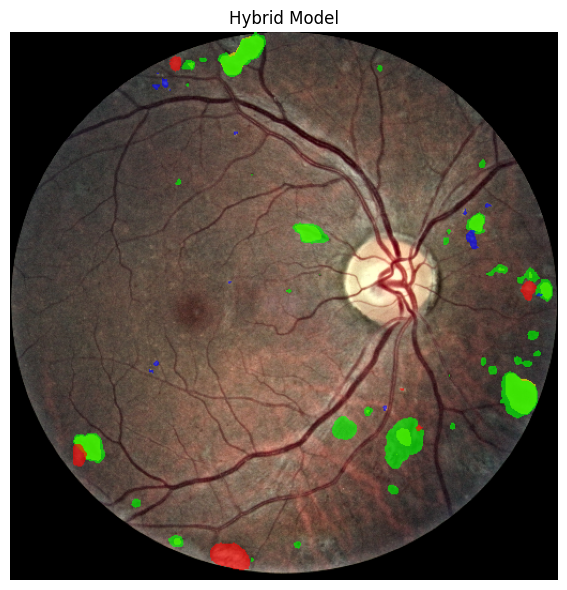

In [43]:
# ==== RUN ON EXAMPLE ====
all_ds = ConcatDataset([ds_train, ds_val, ds_test])  # if not already created
predict_and_plot(all_ds, image_id="1686_3")

In [44]:
import os, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import cv2  # <-- added

# Expected globals:
# - config["IMAGE_ROOT"], config["MASK_DIR"]
# - COLORS dict with MA/HE/EX/SE np.array RGB (0..1 or 0..255; we'll normalize)
# - image_id you want to view (string like "0000_1")

LESIONS = ["MA", "HE", "EX", "SE"]
SUBDIRS = {
    "MA": "Microaneurysms_Masks",
    "HE": "Hemorrhage_Masks",
    "EX": "HardExudate_Masks",
    "SE": "SoftExudate_Masks",
}
EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

def _to_color_vec(c):
    c = np.asarray(c, dtype=np.float32)
    return c if c.max() <= 1.0 else c / 255.0

def _norm_colors(colors):
    return {k: _to_color_vec(v) for k, v in colors.items()}

def _stem(fname):
    r, _ = os.path.splitext(os.path.basename(fname))
    return r

def _load_rgb(path):
    """Load image as RGB [0,1] with CLAHE applied on L channel."""
    img = np.array(Image.open(path).convert("RGB"))
    # apply CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return img_clahe.astype(np.float32) / 255.0

def _load_mask_bin(path, target_hw):
    m = Image.open(path).convert("L")
    if m.size[::-1] != target_hw:  # PIL size=(W,H)
        m = m.resize((target_hw[1], target_hw[0]), resample=Image.NEAREST)
    m = np.array(m)
    return (m > 0).astype(np.float32)  # HxW

def _find_image_recursive(image_root, image_id):
    image_id = str(image_id)
    for dp, _, files in os.walk(image_root):
        for fn in files:
            if fn.lower().endswith(EXTS) and _stem(fn) == image_id:
                return os.path.join(dp, fn)
    for dp, _, files in os.walk(image_root):
        for fn in files:
            if fn.lower().endswith(EXTS) and _stem(fn).startswith(image_id):
                return os.path.join(dp, fn)
    raise FileNotFoundError(f"RGB image for '{image_id}' not found under {image_root}")

def _find_mask_in_folder(folder, image_id):
    image_id = str(image_id)
    if not os.path.isdir(folder):
        return None
    for fn in os.listdir(folder):
        if fn.lower().endswith(EXTS) and _stem(fn) == image_id:
            return os.path.join(folder, fn)
    for fn in os.listdir(folder):
        if fn.lower().endswith(EXTS) and _stem(fn).startswith(image_id):
            return os.path.join(folder, fn)
    return None

def overlay_four_masks_from_dirs(image_id, alpha=0.45, verbose=True):
    img_path = _find_image_recursive(config["IMAGE_ROOT"], image_id)
    img = _load_rgb(img_path)  # HxWx3 in [0,1], CLAHE applied
    H, W = img.shape[:2]

    colors = _norm_colors(COLORS)
    overlay = np.zeros_like(img, dtype=np.float32)
    found_any = False

    for lesion in LESIONS:
        folder = os.path.join(config["MASK_DIR"], SUBDIRS[lesion])
        mpath = _find_mask_in_folder(folder, image_id)
        if mpath is None:
            if verbose:
                print(f"[warn] {lesion}: no mask for '{image_id}' in {folder}")
            continue
        m = _load_mask_bin(mpath, (H, W))  # HxW
        if m.max() > 0:
            overlay += m[..., None] * colors[lesion]
            found_any = True

    overlay = np.clip(overlay, 0.0, 1.0)
    comp = (1 - alpha) * img + alpha * overlay if found_any else img
    if verbose and not found_any:
        print("[info] no masks found; showing original only")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(comp)
    ax.set_title(f"Original")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

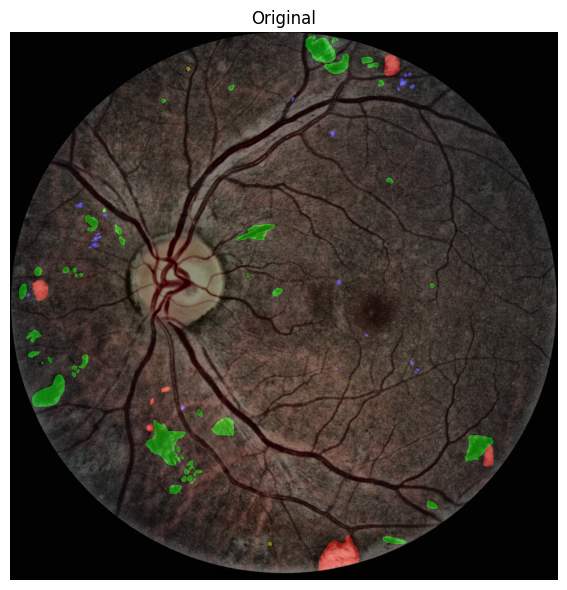

In [ ]:
overlay_four_masks_from_dirs("1686_3", alpha=0.45)

In [56]:
lesion_models["MA"], lesion_models["EX"] = lesion_models["EX"], lesion_models["MA"]

@torch.no_grad()
def predict_and_plot_per_class(dataset, image_id, thresholds=None, alpha=0.65, show_on_rgb=True):
    # --- locate example ---
    plot_order = ["EX", "HE", "MA", "SE"]
    candidates = []
    for subds in _iter_subdatasets(dataset):
        for li in range(len(subds)):
            if str(get_image_id(subds, li)) == str(image_id):
                candidates.append((subds, li))
    if not candidates:
        raise KeyError(f"image_id '{image_id}' not found in dataset")

    def is_eval(sub): return bool(getattr(sub, "train_mode", False) == False)
    candidates.sort(key=lambda x: (not is_eval(x[0])))  # eval first
    subds, li = candidates[0]

    # --- fetch tensors ---
    image, patch, _ = subds[li]
    img_in, patch_in = image.unsqueeze(0).to(device), patch.unsqueeze(0).to(device)

    # --- enforce RGB base in [0,1] float32 ---
    rgb_uint8 = denorm_to_uint8(image)
    if rgb_uint8.ndim == 2:
        rgb_uint8 = rgb_uint8[..., None]
    if rgb_uint8.shape[-1] == 1:
        rgb_uint8 = np.repeat(rgb_uint8, 3, axis=-1)
    elif rgb_uint8.shape[-1] > 3:
        rgb_uint8 = rgb_uint8[..., :3]
    rgb = rgb_uint8.astype(np.float32) / 255.0
    H, W = rgb.shape[:2]

    # --- per-class predictions and plots ---
    for name in plot_order:
        model = lesion_models[name]
        out = model(img_in, patch_in)
        logits = out[0] if isinstance(out, (tuple, list)) else out
        if logits.dim() == 3:
            logits = logits.unsqueeze(0)
        if logits.shape[-2:] != (H, W):
            logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
        probs = torch.sigmoid(logits)  # (1,1,H,W)
        thr = 0.5 if thresholds is None else float(thresholds.get(name, 0.5))
        mask = (probs >= thr).float()[0, 0].detach().cpu().numpy()  # HxW in {0,1}

        color = COLORS.get(name, np.array([1.0, 1.0, 1.0], dtype=np.float32)).astype(np.float32)

        if show_on_rgb:
            # overlay on the RGB base
            comp = np.where(mask[..., None] > 0,
                            alpha * color + (1.0 - alpha) * rgb,
                            rgb)
        else:
            # mask-only on black background
            comp = (mask[..., None] * color).astype(np.float32)

        # --- plot this class only ---
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(comp)
        ax.set_title(f"{name} Prediction")
        ax.axis("off")
        plt.tight_layout()
        plt.show()

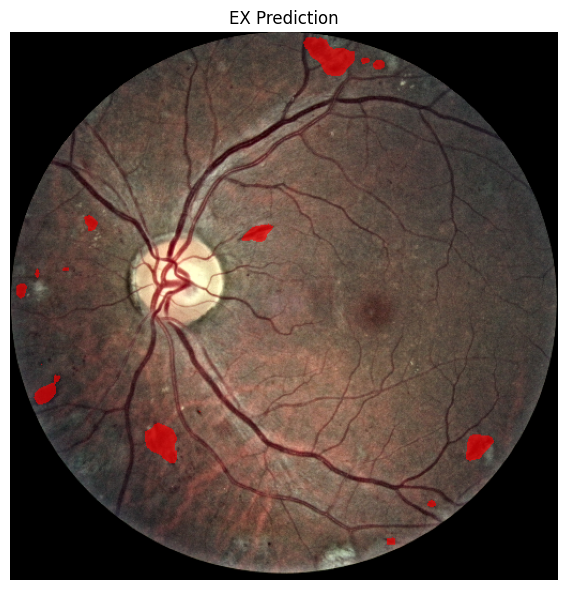

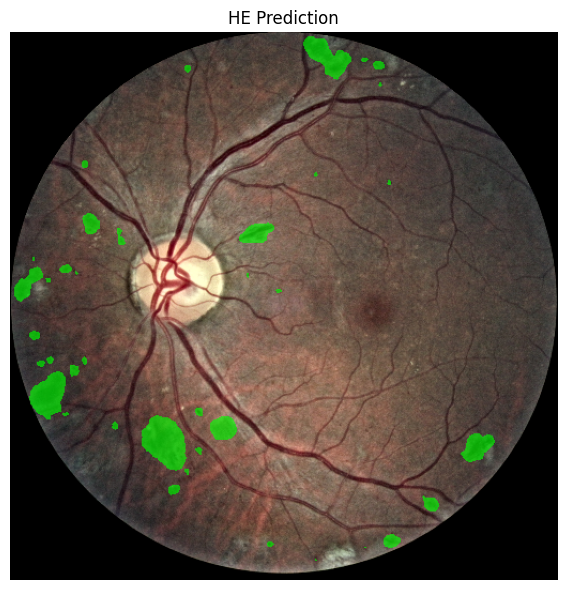

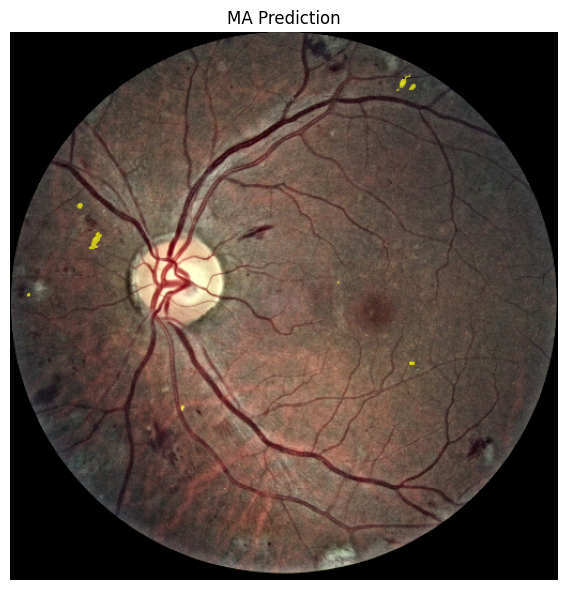

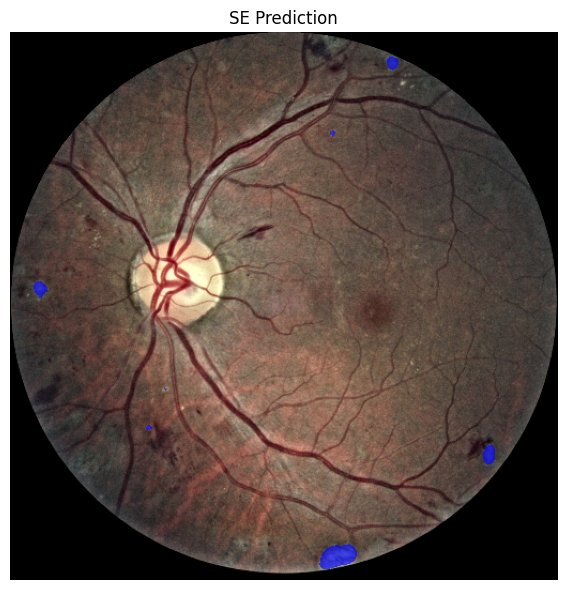

In [58]:
predict_and_plot_per_class(all_ds, "1686_3", thresholds=None, alpha=0.65, show_on_rgb=True)